In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage

/home/abhigupta/anaconda/envs/vice/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
W0203 23:09:34.916996 140210631558912 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [2]:
tf.enable_eager_execution()

In [3]:
# First HW run
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2019-12-31T15-29-04-free_screw_trial/55d23330-algorithm=MultiVICEGAN-seed=7974_2019-12-31_15-29-054ho59z0p/'

# Black box run
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-06T15-03-34-free_screw_hardware/c4a3c92e-algorithm=MultiVICEGAN-seed=9406_2020-01-06_15-03-35lgcbn26r/'
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-09T22-54-26-free_screw_hardware_black_box_from_ckpt_500/0b4d7286-algorithm=MultiVICEGAN-seed=6533_2020-01-09_22-54-27dynczs62'

# More friction run
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-14T20-14-54-free_screw_hardware_black_box_more_friction/95bb78c0-algorithm=MultiVICEGAN-seed=9322_2020-01-14_20-14-55ofvx13is'

# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-20T12-38-50-free_screw_hardware_black_box_more_friction_softerlight_datacollect/ddf4744a-algorithm=MultiVICEGAN-seed=710_2020-01-20_12-38-51jlvxhwjy'
# checkpoint_to_analyze = '50'

# Lighting fix run
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-23T20-48-53-free_screw_hardware_lighting_fix_run_1/d2e00f7c-algorithm=MultiVICEGAN-seed=1123_2020-01-23_20-48-54d6pmb6gp'
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-01-26T18-14-29-free_screw_hardware_lighting_fix_run_1_restored_from_ckpt_350/c0a1cbaa-algorithm=MultiVICEGAN-seed=2561_2020-01-26_18-14-30x4o_u35m'
# experiment_root = '/home/abhigupta/ray_results/gym/DClaw/TurnFreeValve3Hardware-v0/2020-02-01T15-46-18-free_screw_hardware_lighting_fix_run_1_restored_from_ckpt_650/0b98b80c-algorithm=MultiVICEGAN-seed=7854_2020-02-01_15-46-19ld0siolz'
# checkpoint_to_analyze = '1000'

# Sim run
experiment_root = '/home/abhigupta/justin/2019-11-23T15-17-13-free_screw_ours_new_evals_run2_0/623a7e62-algorithm=MultiVICEGAN-seed=878_2019-11-23_15-17-14l6uw2om8'
checkpoint_to_analyze = '600'

In [4]:
with open(os.path.join(experiment_root, f'checkpoint_{checkpoint_to_analyze}/checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

/home/abhigupta/Libraries/vice/softlearning/models/convnet.py:895: UserWarning: softlearning.rnd.utils is not loaded, but a Lambda layer uses it. It may cause errors.
W0203 23:09:42.267773 140210631558912 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0203 23:09:42.342039 140210631558912 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0203 23:09:42.413025 140210631558912 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0203 23:09:42.487648 140210631558912 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0203 23:09:42.557222 140210631558912 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0203 23:09:42.629416 140210631558912 hdf5_format.py:171] 

# Examine Goal Classifier

## 1. Load the replay pools

In [5]:
# load pools
num_replay_pools = 2
def get_replay_pools_pickle_paths(checkpoint_dir):
    return [os.path.join(checkpoint_dir, f'replay_pool_{i}.pkl')
            for i in range(num_replay_pools)]

experience_paths_per_replay_pool = [get_replay_pools_pickle_paths(checkpoint_dir) 
 for checkpoint_dir in sorted(glob.iglob(os.path.join(experiment_root, 'checkpoint_*')))]

from softlearning.replay_pools.utils import get_replay_pool_from_variant
variant = checkpoint['variant']
training_environment = checkpoint['training_environment']
replay_pools = [get_replay_pool_from_variant(variant, training_environment) for _ in range(num_replay_pools)]

for experience_paths in experience_paths_per_replay_pool:
    for i, experience_path in enumerate(experience_paths):
        replay_pools[i].load_experience(experience_path)

In [6]:
# Forward policy replay pool
fw_replay_pool = replay_pools[0]

In [15]:
replay_pools[0].data.keys()

dict_keys([('observations', 'claw_qpos'), ('observations', 'last_action'), ('observations', 'object_xy_position'), ('observations', 'object_z_orientation_cos'), ('observations', 'object_z_orientation_sin'), ('observations', 'pixels'), ('next_observations', 'claw_qpos'), ('next_observations', 'last_action'), ('next_observations', 'object_xy_position'), ('next_observations', 'object_z_orientation_cos'), ('next_observations', 'object_z_orientation_sin'), ('next_observations', 'pixels'), ('actions',), ('rewards',), ('terminals',), ('episode_index_forwards',), ('episode_index_backwards',)])

In [7]:
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
fw_pixels = replay_pools[0].data[('observations', 'pixels')][non_zero_rows]

## 2. Load the goal classifiers & calculate rewards of the pool

In [8]:
rw_classifiers = checkpoint['reward_classifiers']

In [9]:
with tf.device('/gpu:0'):
    rewards = rw_classifiers[0].predict(fw_pixels)

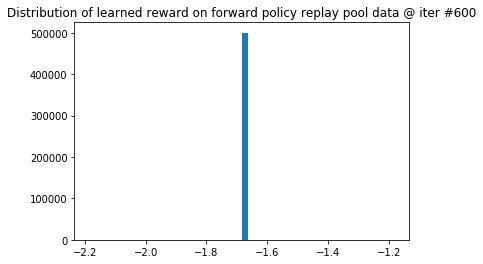

In [10]:
plt.hist(rewards, bins=50)
plt.title(f'Distribution of learned reward on forward policy replay pool data @ iter #{checkpoint_to_analyze}')
plt.show()

### Reward distribution statistics

In [11]:
reward_mean = np.mean(rewards)
reward_median = np.median(rewards)
reward_stdev = np.std(rewards)

print('MEAN:', reward_mean)
print('MEDIAN:', reward_median)
print('STD DEV:', reward_stdev)

MEAN: -1.6836318
MEDIAN: -1.6836312
STD DEV: 5.9604645e-07


In [12]:
def plot_grid(imgs, labels=None):
    n_images = len(imgs)
    n_columns = np.sqrt(n_images)
    n_rows = np.ceil(n_images / n_columns) + 1
    plt.figure(figsize=(5 * n_columns, 5 * n_rows))
    for i, img in enumerate(imgs):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.imshow(img)
        if labels is not None:
            plt.title(labels[i], fontsize=20)
    plt.show()

## High Valued Logits (based on the above histogram)
These should resemble the goal image.

# of images: 500000
3 SD ABOVE MEAN (reward > -1.6836299896240234)


/home/abhigupta/anaconda/envs/vice/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


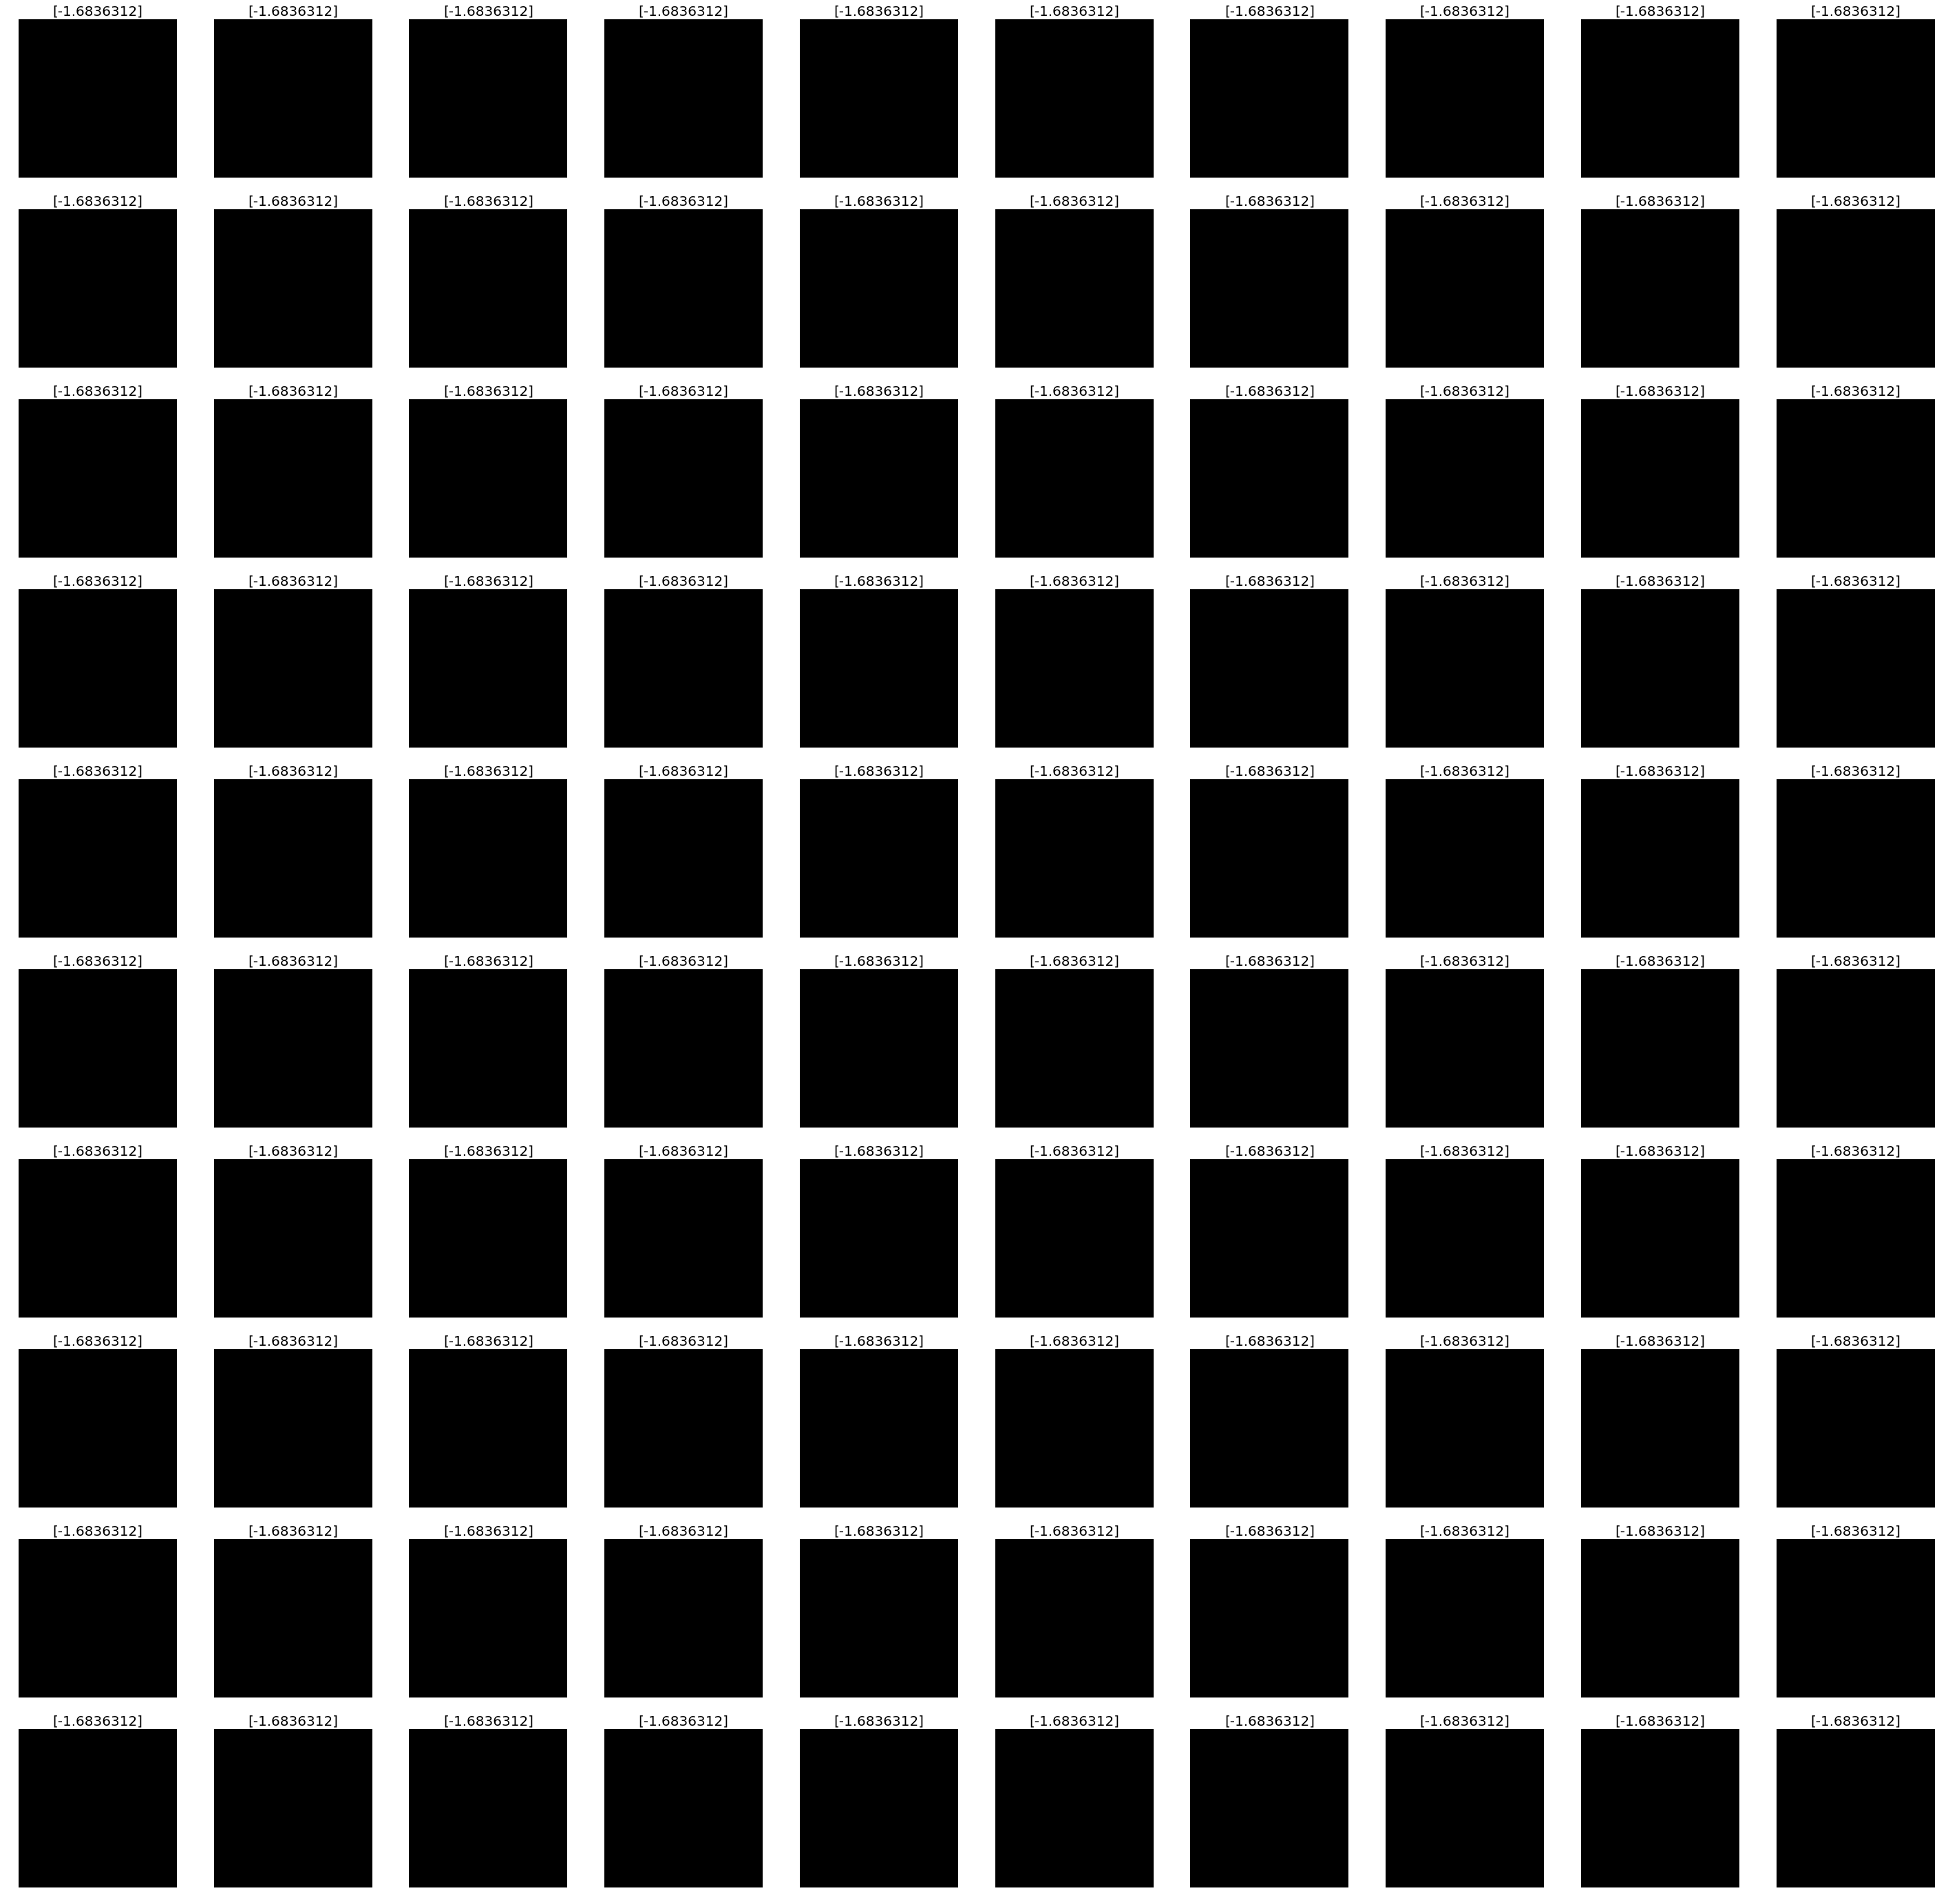

In [13]:
rw_filter = (rewards > reward_mean + 0 * reward_stdev).squeeze()
above_3sd_rw = rewards[rw_filter]
above_3sd_img = fw_pixels[rw_filter]
print('# of images:', above_3sd_img.shape[0])
print(f'3 SD ABOVE MEAN (reward > {reward_mean + 3 * reward_stdev})')
plot_grid(
    above_3sd_img[np.random.randint(above_3sd_img.shape[0],
                                size=min(100, above_3sd_img.shape[0]))],
    labels=above_3sd_rw
)

## Low Valued Logits
These should resemble negatives.

# of images: 260


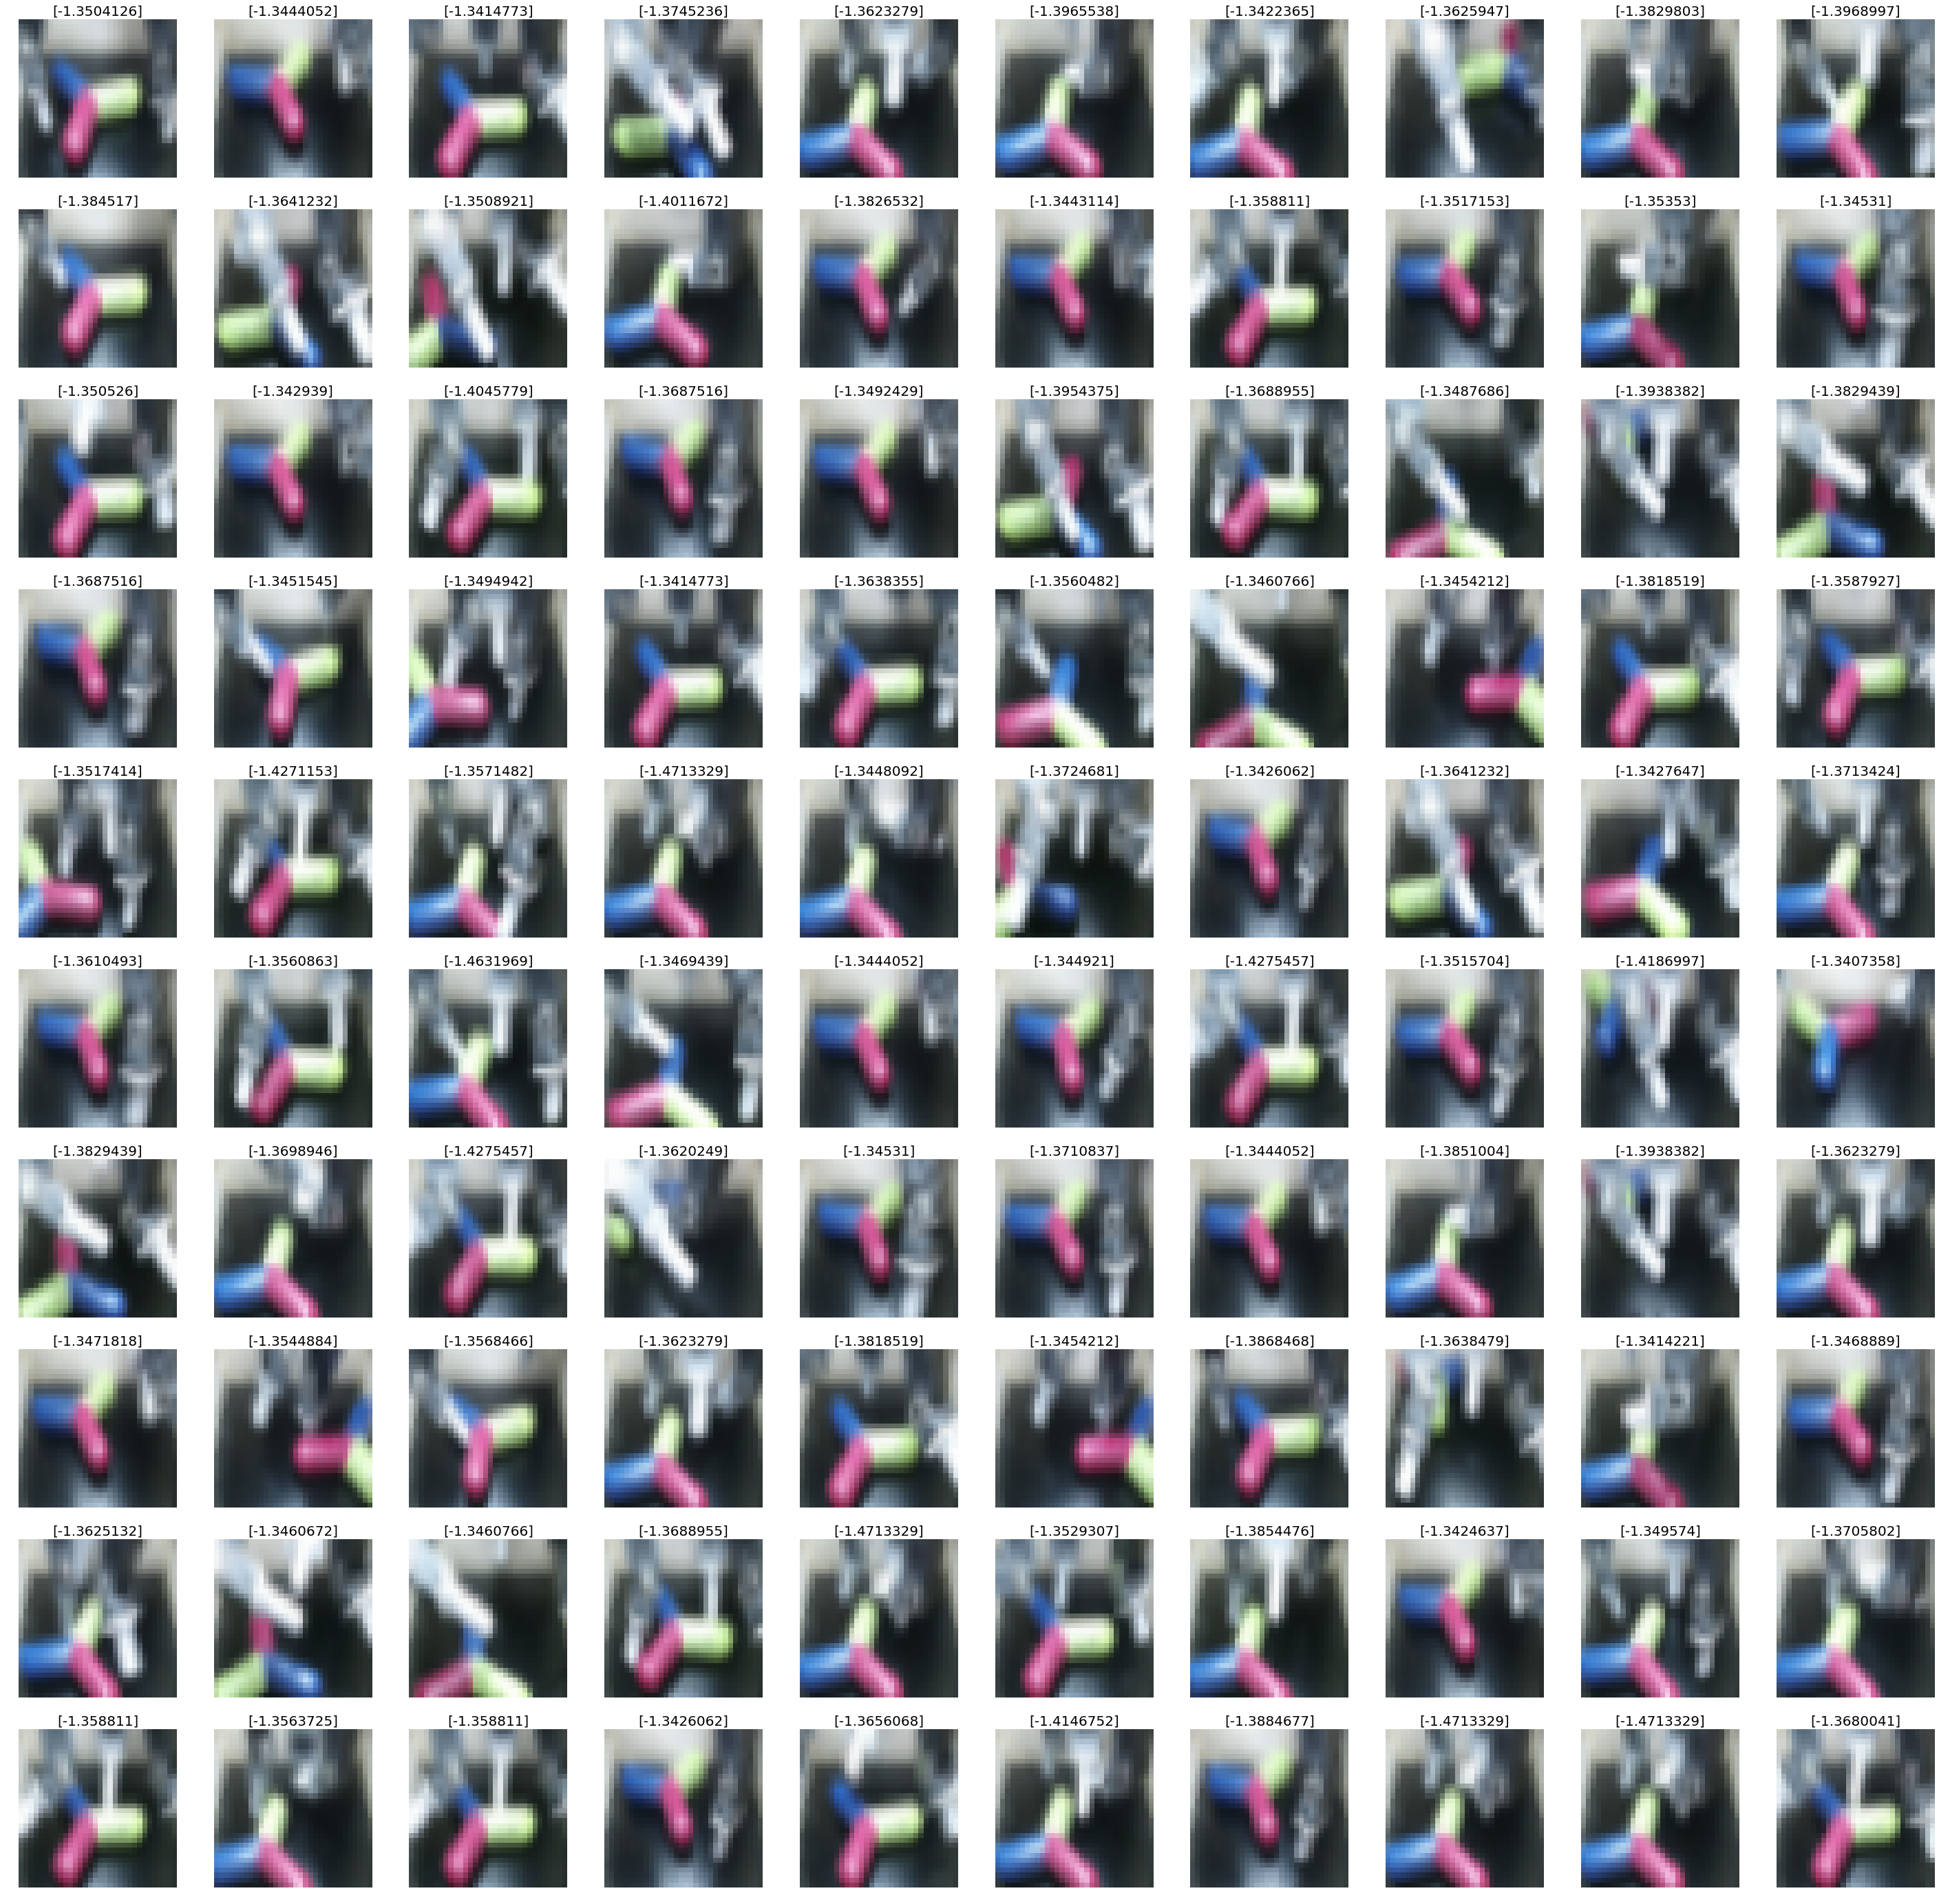

In [109]:
rw_filter = (rewards < reward_mean - 0.75 * reward_stdev).squeeze()
# rw_filter = np.logical_and(rewards < 0.1,
#                            rewards > 0).squeeze()
rw = rewards[rw_filter]
img = fw_pixels[rw_filter]
print('# of images:', img.shape[0])
# print(f'2 SD BELOW MEAN (reward < {reward_mean - 2 * reward_stdev})')

rand_sample = np.random.randint(img.shape[0],
                                size=min(100, img.shape[0]))
plot_grid(img[rand_sample], labels=rw[rand_sample])

## Near the mean

WITHIN 1 SD OF MEAN (-1.2841335535049438 < reward < -0.8017619848251343)


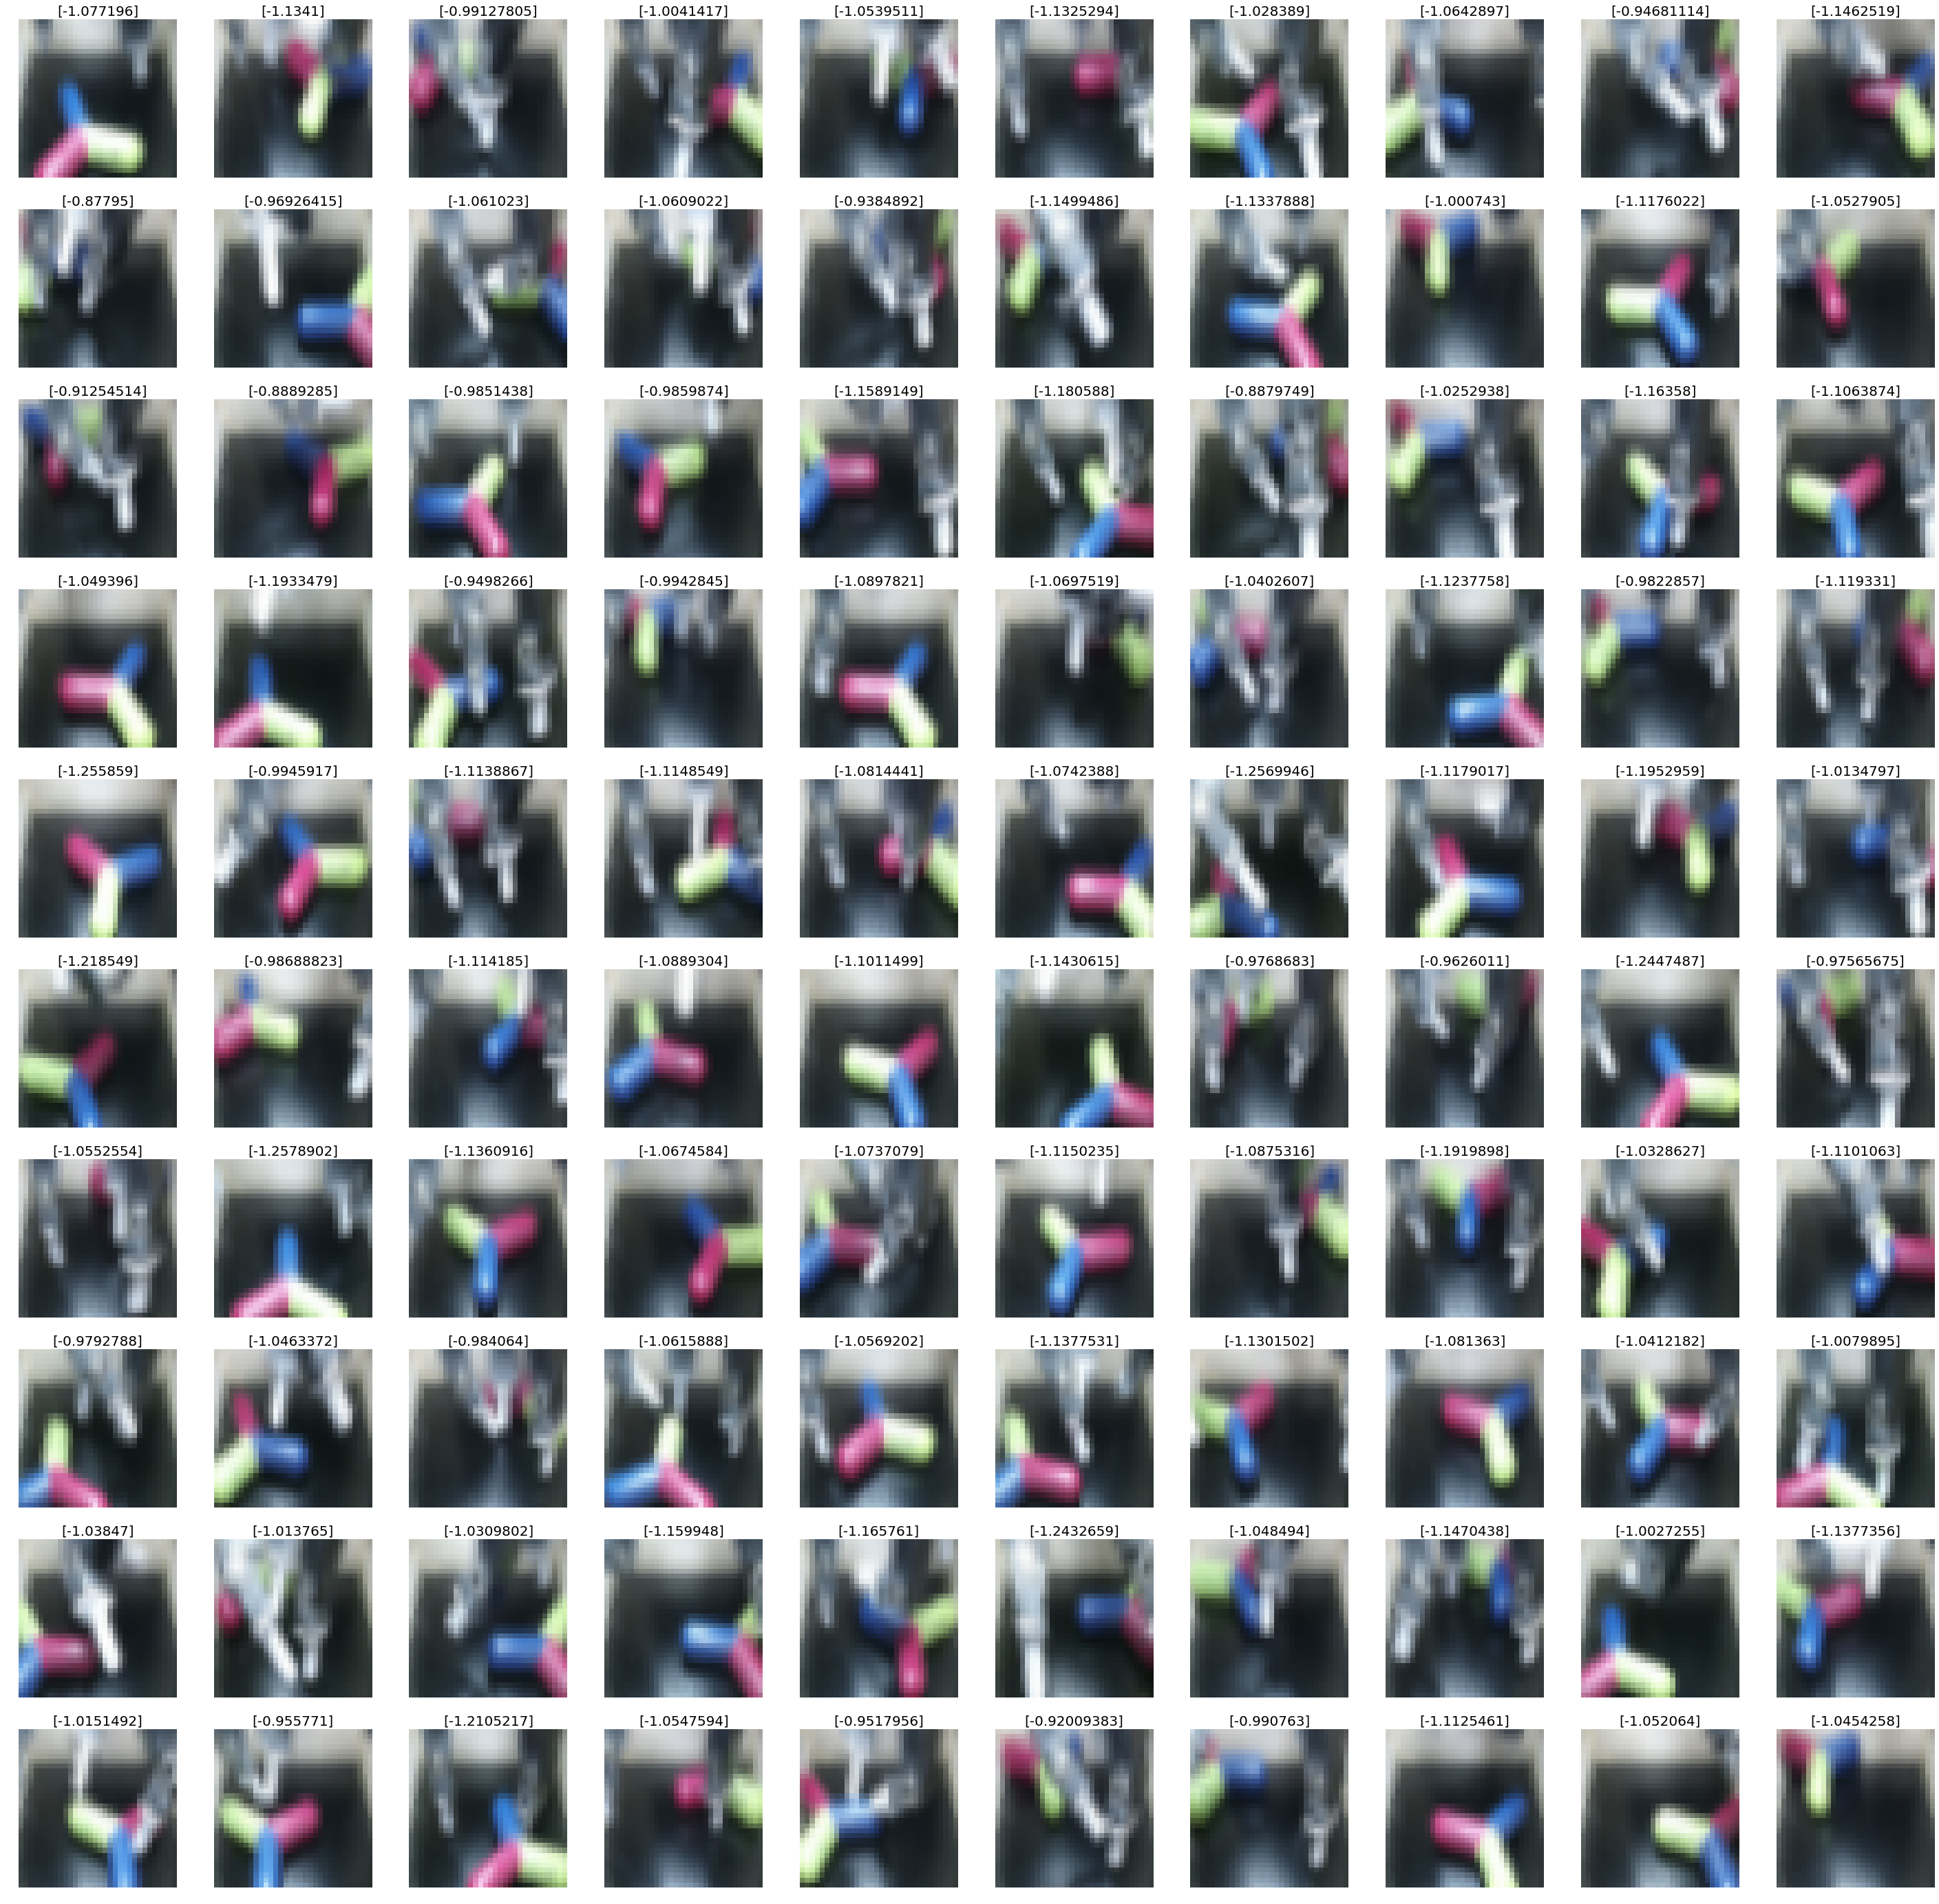

In [21]:
rw_filter = np.logical_and(rewards < reward_mean + reward_stdev,
                           rewards > reward_mean - reward_stdev).squeeze()
rw = rewards[rw_filter]
img = fw_pixels[rw_filter]
print(f'WITHIN 1 SD OF MEAN ({reward_mean - reward_stdev} < reward < {reward_mean + reward_stdev})')

rand_sample = np.random.randint(img.shape[0],
                                size=min(100, img.shape[0]))
plot_grid(img[rand_sample], labels=rw[rand_sample])

# Get New Positives

In [ ]:
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
non_zero_rows.sum()

In [33]:
# new_pos_inds = np.where(np.logical_or(rewards < reward_mean - 1.9 * reward_stdev,
#                                       rewards > reward_mean + 8 * reward_stdev).squeeze())[0]
new_pos_inds = np.where(rewards > reward_mean + 6 * reward_stdev)[0]

In [36]:
np.random.shuffle(new_pos_inds)
new_pos_inds

array([ 99353,  23432, 198998, ...,  93224, 190742,  64714])

In [37]:
new_positives = {}
for key, val in replay_pools[0].data.items():
    if len(key) > 1:
        new_positives[key[1]] = val[non_zero_rows][new_pos_inds]

In [ ]:
with open(os.path.join('/home/abhigupta/Libraries/vice/goal_pools/free_screw_hw_/', 'positives.pkl'), 'wb') as file:
    pickle.dump(new_positives, file)

In [39]:
new_positives['pixels'].shape

(2336, 32, 32, 3)

In [38]:
with open(os.path.join('/home/abhigupta/Libraries/vice/goal_pools/free_screw_lighting_fix/', 'positives_old.pkl'), 'rb') as f:
    old_positives = pickle.load(f)

In [ ]:
old_positives['pixels'].shape
plot_grid(old_positives['pixels'][:100])

In [40]:
positives = {
    k: np.concatenate([old_positives[k], new_positives[k]])
    for k in new_positives
}

In [41]:
positives['pixels'].shape

(2651, 32, 32, 3)

In [42]:
with open(os.path.join('/home/abhigupta/Libraries/vice/goal_pools/free_screw_lighting_fix/', 'positives.pkl'), 'wb') as f:
    pickle.dump(positives, f)

# Lighting Normalization

In [ ]:
with open(os.path.join('/home/abhigupta/Libraries/vice/goal_pools/free_screw_hw_online/', 'positives.pkl'), 'rb') as file:
    positives = pickle.load(file)

In [ ]:
positives['pixels'].shape

In [ ]:
plt.imshow(positives['pixels'][1000])

In [ ]:
positives['pixels'][1000].mean()

In [ ]:
plt.imshow(fw_pixels[2000])

In [ ]:
fw_pixels[2000].mean()

In [ ]:
plt.imshow(fw_pixels[2000] * positives['pixels'][1000].mean() / fw_pixels[2000].mean())

# Examine RND

In [ ]:
checkpoint.keys()

In [ ]:
from softlearning.rnd.utils import get_rnd_networks_from_variant
num_goals = 2
rnd_networks = checkpoint['rnd_networks']

In [ ]:
rnd_networks

In [ ]:
target_network, predictor_network = rnd_networks[1]
non_zero_rows = replay_pools[1].data[('observations', 'claw_qpos')].any(axis=-1)
data = {key: val[non_zero_rows] for key, val in replay_pools[1].data.items()}

In [ ]:
step_size = 50000
data_chunks = []
for start_idx in range(0, data[('observations', 'pixels')].shape[0], step_size):
    data_chunk = {}
    for key, val in data.items():
        if isinstance(key, tuple) and len(key) > 1:
            key = key[-1]
            data_chunk[key] = val[start_idx:start_idx+step_size, ...]
    data_chunks.append(data_chunk)


In [ ]:
data_chunks[0].keys()

In [ ]:
with tf.device('/gpu:1'):
    targets_np = np.concatenate([
        target_network(chunk).numpy() for chunk in data_chunks
    ])
    predictions_np = np.concatenate([
        predictor_network(chunk).numpy() for chunk in data_chunks
    ])
    mse = np.square(targets_np - predictions_np).mean(axis=1)

In [ ]:
plt.hist(mse, bins=500)
plt.show()

In [ ]:
rnd_err_threshold = 0.05
rnd_err_mask = (mse > rnd_err_threshold).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]

In [ ]:
n_entries = 100
np.random.shuffle(rnd_err_indices)
high_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = high_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

In [ ]:
rnd_err_mask = np.logical_and(mse < 0.03, mse > 0.02).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]
n_entries = 100
np.random.shuffle(rnd_err_indices)
low_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = low_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

In [ ]:
rnd_err_threshold = 0.01
rnd_err_mask = (mse < rnd_err_threshold).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]
n_entries = 100
np.random.shuffle(rnd_err_indices)
low_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = low_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

In [ ]:
target_network, predictor_network = rnd_networks[0]
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
data = {key: val[non_zero_rows] for key, val in replay_pools[0].data.items()}

In [ ]:
step_size = 50000
data_chunks = []
for start_idx in range(0, data[('observations', 'pixels')].shape[0], step_size):
    data_chunk = {}
    for key, val in data.items():
        if isinstance(key, tuple) and len(key) > 1:
            key = key[-1]
            data_chunk[key] = val[start_idx:start_idx+step_size, ...]
    data_chunks.append(data_chunk)


In [ ]:
data_chunks[0].keys()

In [ ]:
with tf.device('/gpu:1'):
    targets_np = np.concatenate([
        target_network(chunk).numpy() for chunk in data_chunks
    ])
    predictions_np = np.concatenate([
        predictor_network(chunk).numpy() for chunk in data_chunks
    ])
    mse = np.square(targets_np - predictions_np).mean(axis=1)

In [ ]:
plt.hist(mse, bins=500)
plt.show()

In [ ]:
rnd_err_mask = (mse > 0.04).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]
n_entries = 100
np.random.shuffle(rnd_err_indices)
low_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = low_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

In [ ]:
rnd_err_mask = (mse < 0.007).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]
n_entries = 100
np.random.shuffle(rnd_err_indices)
low_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = low_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

In [ ]:
rnd_err_mask = np.logical_and(mse > 0.007, mse < 0.01).astype(bool)
rnd_err_indices = np.where(rnd_err_mask == True)[0]
n_entries = 100
np.random.shuffle(rnd_err_indices)
low_rnd_error_pixels = data[('observations', 'pixels')][rnd_err_indices]
imgs = low_rnd_error_pixels[:n_entries]

import math
n_columns = np.sqrt(n_entries)
n_rows = math.ceil(n_entries / n_columns) + 1
plt.figure(figsize=(5 * n_columns, 5 * n_rows))
for i, img in enumerate(imgs):
    plt.subplot(n_rows, n_columns, i+1)
    plt.axis('off')
    plt.title("{0:.4f}".format(mse[rnd_err_indices[i]]), fontsize=30)
    plt.imshow(img)

# Get New VAE Data

In [ ]:
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
data_0 = {}
for key, val in replay_pools[0].data.items():
    if len(key) > 1:
        data_0[key[1]] = val[non_zero_rows]

In [ ]:
non_zero_rows = replay_pools[1].data[('observations', 'claw_qpos')].any(axis=-1)
data_1 = {}
for key, val in replay_pools[1].data.items():
    if len(key) > 1:
        data_1[key[1]] = val[non_zero_rows]

In [ ]:
new_vae_data = {}
for key in data_0.keys():
    new_vae_data[key] = np.append(data_0[key], data_1[key], axis=0)

In [ ]:
with gzip.open('/home/abhigupta/Libraries/vice/notebooks/rl_collected_data_free_screw_hw.pkl', 'wb') as f:
    pickle.dump(new_vae_data, f, protocol=4)

In [ ]:
3 + 4

# Examine VAE

In [8]:
checkpoint.keys()

dict_keys(['variant', 'training_environment', 'evaluation_environment', 'algorithm', 'policy_weights', 'rnd_networks', 'reward_classifiers'])

In [22]:
vae_dir = '/home/abhigupta/Libraries/vice/softlearning/models/hardware_free_screw_vae_black_box'
encoder_path = os.path.join(vae_dir, 'encoder_32_dim_0.5_beta_final.h5')
decoder_path = os.path.join(vae_dir, 'decoder_32_dim_0.5_beta_final.h5')
encoder_path, decoder_path

('/home/abhigupta/Libraries/vice/softlearning/models/hardware_free_screw_vae_black_box/encoder_32_dim_0.5_beta_final.h5',
 '/home/abhigupta/Libraries/vice/softlearning/models/hardware_free_screw_vae_black_box/decoder_32_dim_0.5_beta_final.h5')

In [23]:
from softlearning.models.utils import get_vae

vae_kwargs = {
    'image_shape': (32, 32, 3),
    'latent_dim': 32,
    'extra_input_shape': (9, )
}

vae = get_vae(encoder_path, decoder_path, **vae_kwargs)

In [19]:
vae.decoder.inputs

[<tf.Tensor 'latent_input_1:0' shape=(?, 41) dtype=float32>]

In [24]:
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
fw_pixels = replay_pools[0].data[('observations', 'pixels')][non_zero_rows]
fw_claw_qpos = replay_pools[0].data[('observations', 'claw_qpos')][non_zero_rows]

In [25]:
rand_idx = np.random.choice(len(fw_pixels), size=100)
sample_pixels = fw_pixels[rand_idx]
sample_claw_qpos = fw_claw_qpos[rand_idx]

In [26]:
sess = tf.keras.backend.get_session()
reconstructions = sess.run(vae.reconstruct((sample_pixels, sample_claw_qpos)))
# reconstructions = vae.reconstruct((sample_pixels, np.zeros_like(sample_claw_qpos))).numpy()

In [27]:
concat = np.concatenate([
    sample_pixels,
    skimage.util.img_as_ubyte(reconstructions),
], axis=2)

/home/abhigupta/anaconda/envs/vice/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


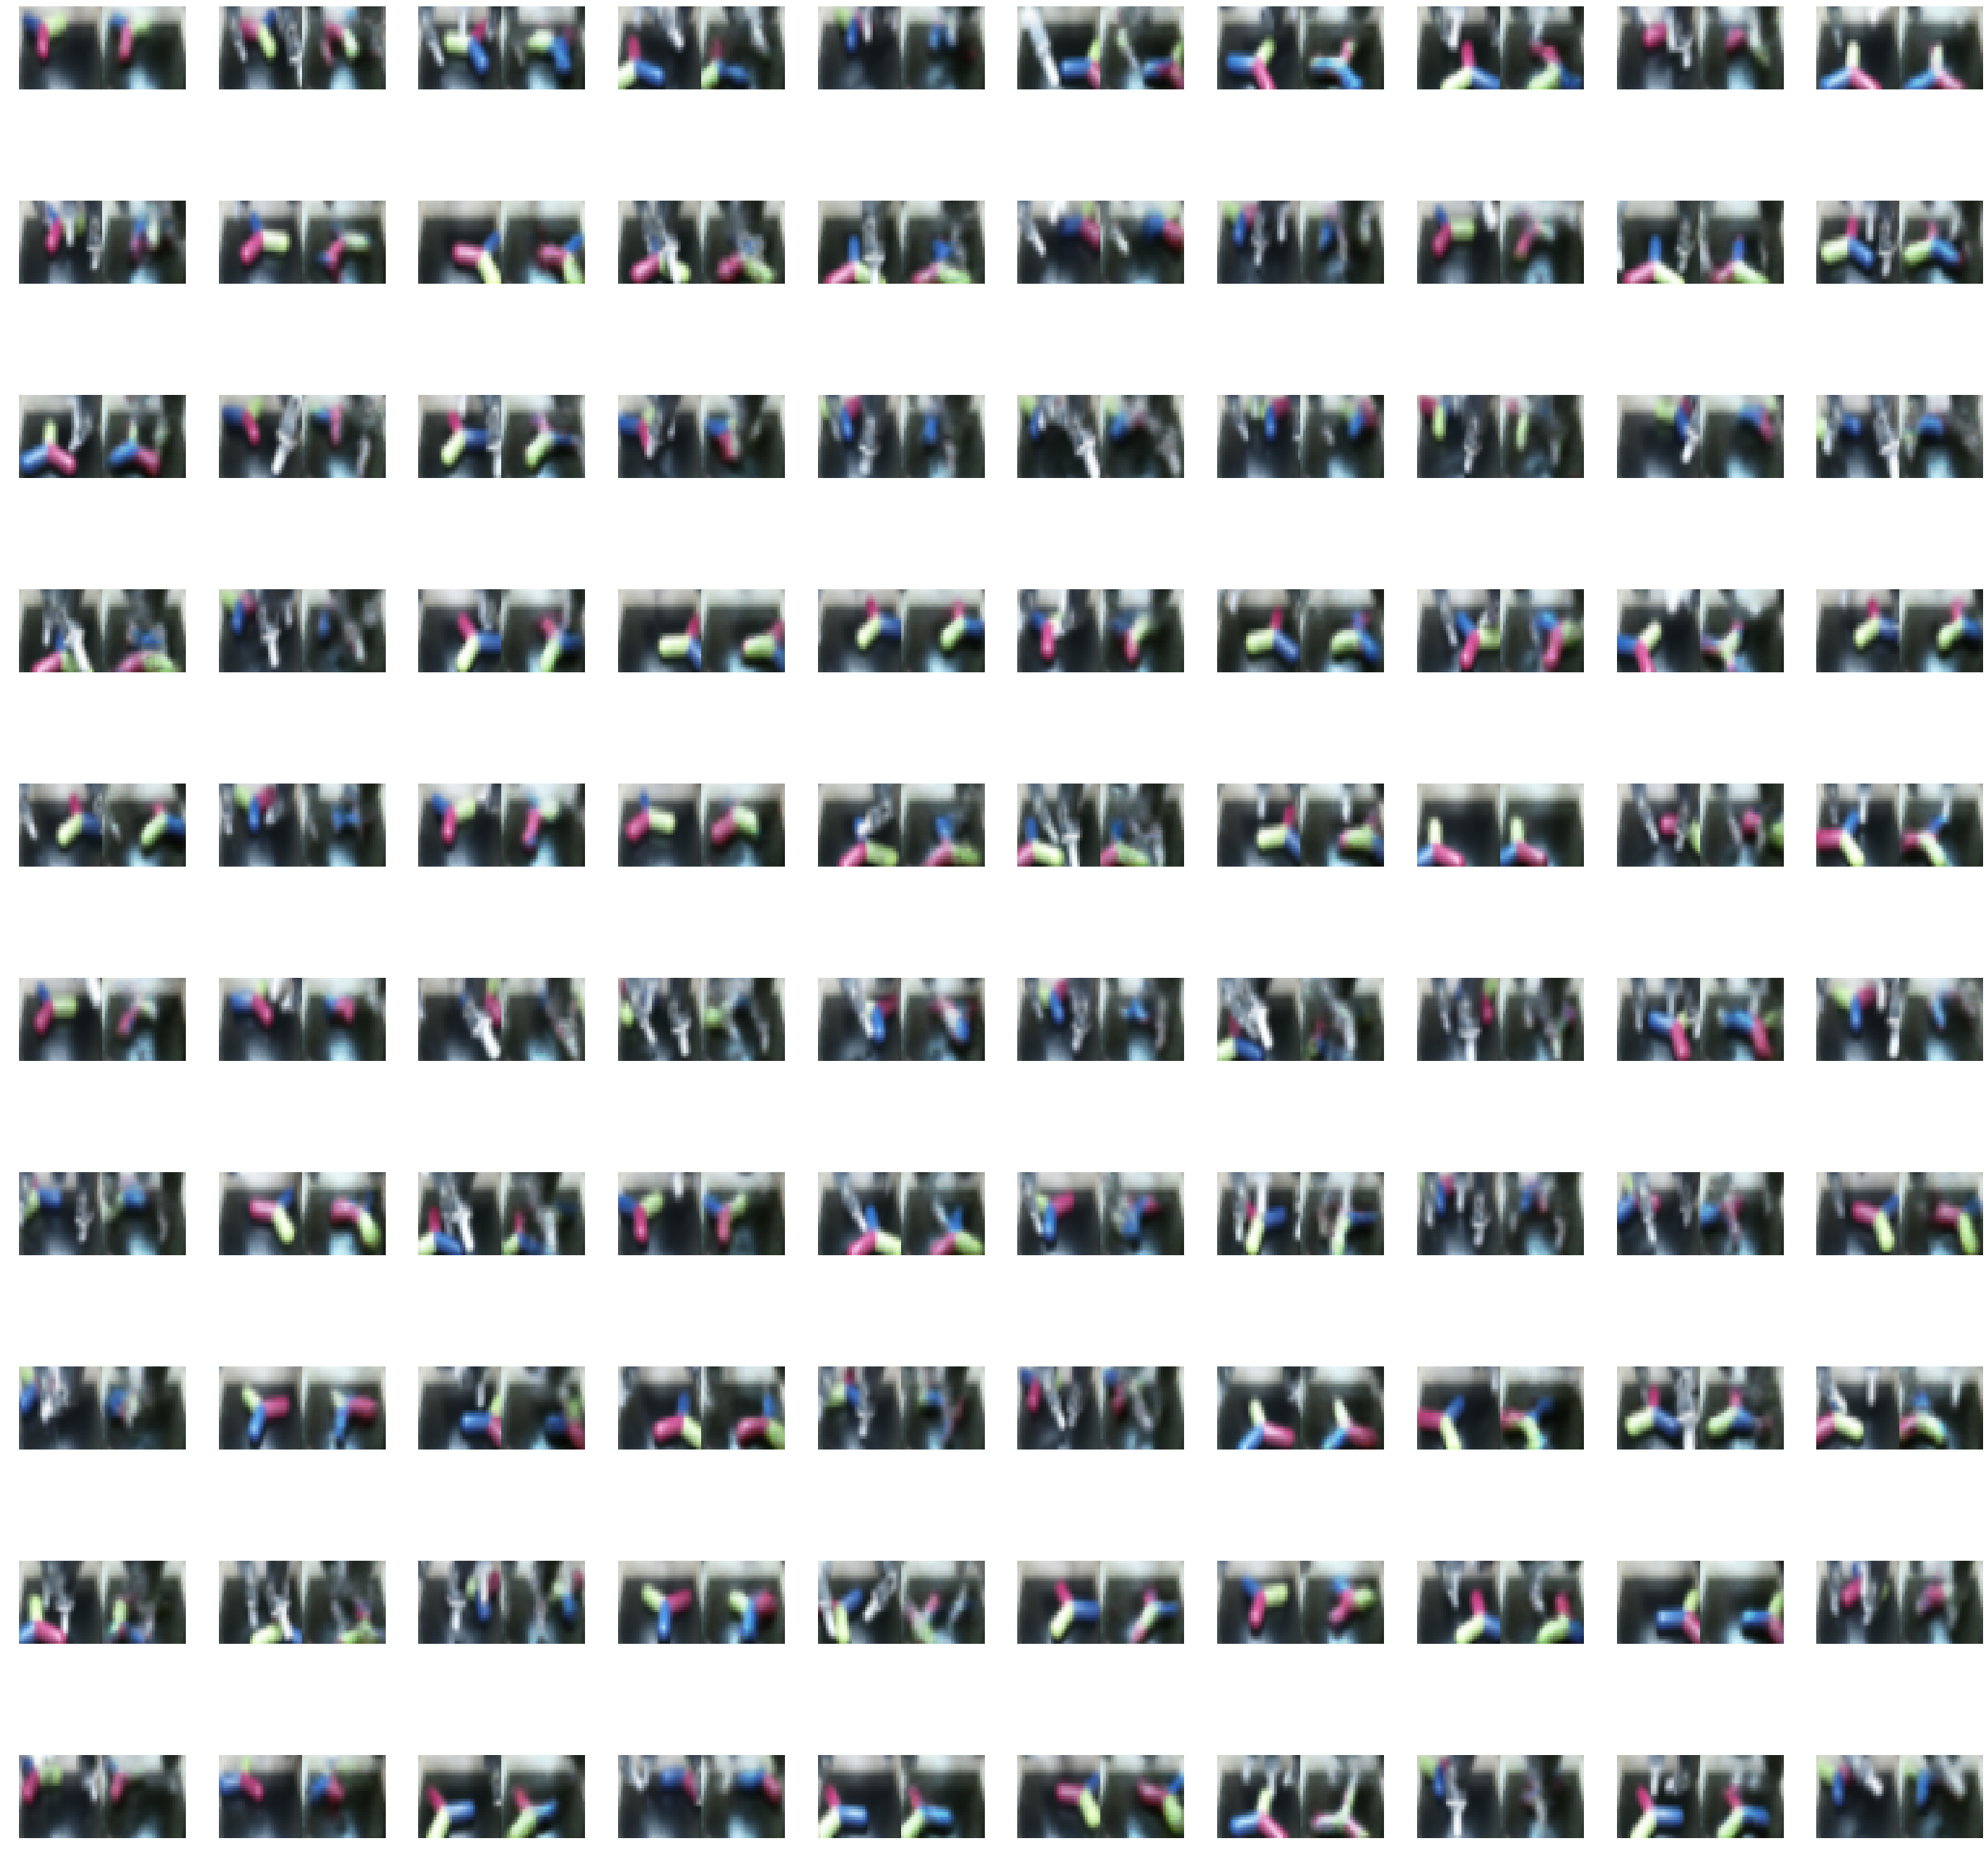

In [28]:
plot_grid(concat)

In [29]:
from softlearning.misc.utils import save_video
from IPython.display import HTML

def get_vae_video(path_length=5000, idx=0):
    start, end = idx * path_length, (idx + 1) * path_length
    gtr_vid = fw_pixels[start:end]
    
    test_input = (gtr_vid, fw_claw_qpos[start:end])
#     test_input = (gtr_vid, np.zeros((path_length, 9)))
#     print(test_input)
    recon_vid = sess.run(vae.reconstruct(test_input))
    print(recon_vid)
    concat_vid = np.concatenate([
        gtr_vid,
        skimage.util.img_as_ubyte(recon_vid),
    ], axis=2)
    save_video(concat_vid, './vid.mp4', fps=30)

In [30]:
get_vae_video(path_length=5000)

[[[[0.7709662  0.80837417 0.7804687 ]
   [0.79974306 0.83323073 0.7991947 ]
   [0.80844545 0.838746   0.80525184]
   ...
   [0.82145345 0.84709704 0.81735206]
   [0.8021493  0.81685925 0.77896   ]
   [0.7616108  0.7712062  0.74014956]]

  [[0.78765583 0.8284266  0.8063042 ]
   [0.8108643  0.8486111  0.8138628 ]
   [0.7998854  0.83526576 0.7920662 ]
   ...
   [0.8159214  0.84042263 0.8035369 ]
   [0.819205   0.8341454  0.7967019 ]
   [0.79015976 0.80908906 0.7849727 ]]

  [[0.80592215 0.8578054  0.84026074]
   [0.8183597  0.86739624 0.83424455]
   [0.788471   0.8280602  0.7836401 ]
   ...
   [0.80218816 0.828338   0.7832681 ]
   [0.83496404 0.8597243  0.8211378 ]
   [0.82364416 0.8486835  0.82661676]]

  ...

  [[0.71233547 0.41404232 0.5136675 ]
   [0.73579735 0.41051745 0.5380705 ]
   [0.68937296 0.41758928 0.52250785]
   ...
   [0.20197755 0.24537978 0.20928746]
   [0.19119114 0.23140019 0.19809133]
   [0.16373804 0.19895914 0.16016865]]

  [[0.68400383 0.36090317 0.47531557]
   [0.6

In [31]:
HTML("""
<video width="320" height="160" controls>
  <source src="./vid.mp4" type="video/mp4">
</video>
""")

In [56]:
test_img = fw_pixels[6]

test = (test_img[None], np.zeros((1, 9)))
plt.imshow(np.concatenate([test_img, skimage.util.img_as_ubyte(vae.reconstruct(test)[0])], axis=1))

NotImplementedError: Cannot convert a symbolic Tensor (strided_slice:0) to a numpy array.

In [178]:
test_img.shape

(32, 32, 3)

In [180]:
 skimage.util.img_as_ubyte(vae.reconstruct(test)[0]).shape

(32, 32, 3)

In [25]:
with open('/home/abhigupta/Libraries/vice/notebooks/free_screw_lighting_fix/positives.pkl', 'rb') as f:
    data = pickle.load(f)

In [26]:
data['pixels'].shape

(315, 32, 32, 3)

In [33]:
reconstructions = vae.reconstruct((data['pixels'], data['claw_qpos'])).numpy()

concat = np.concatenate([
    data['pixels'],
    skimage.util.img_as_ubyte(reconstructions),
], axis=2)

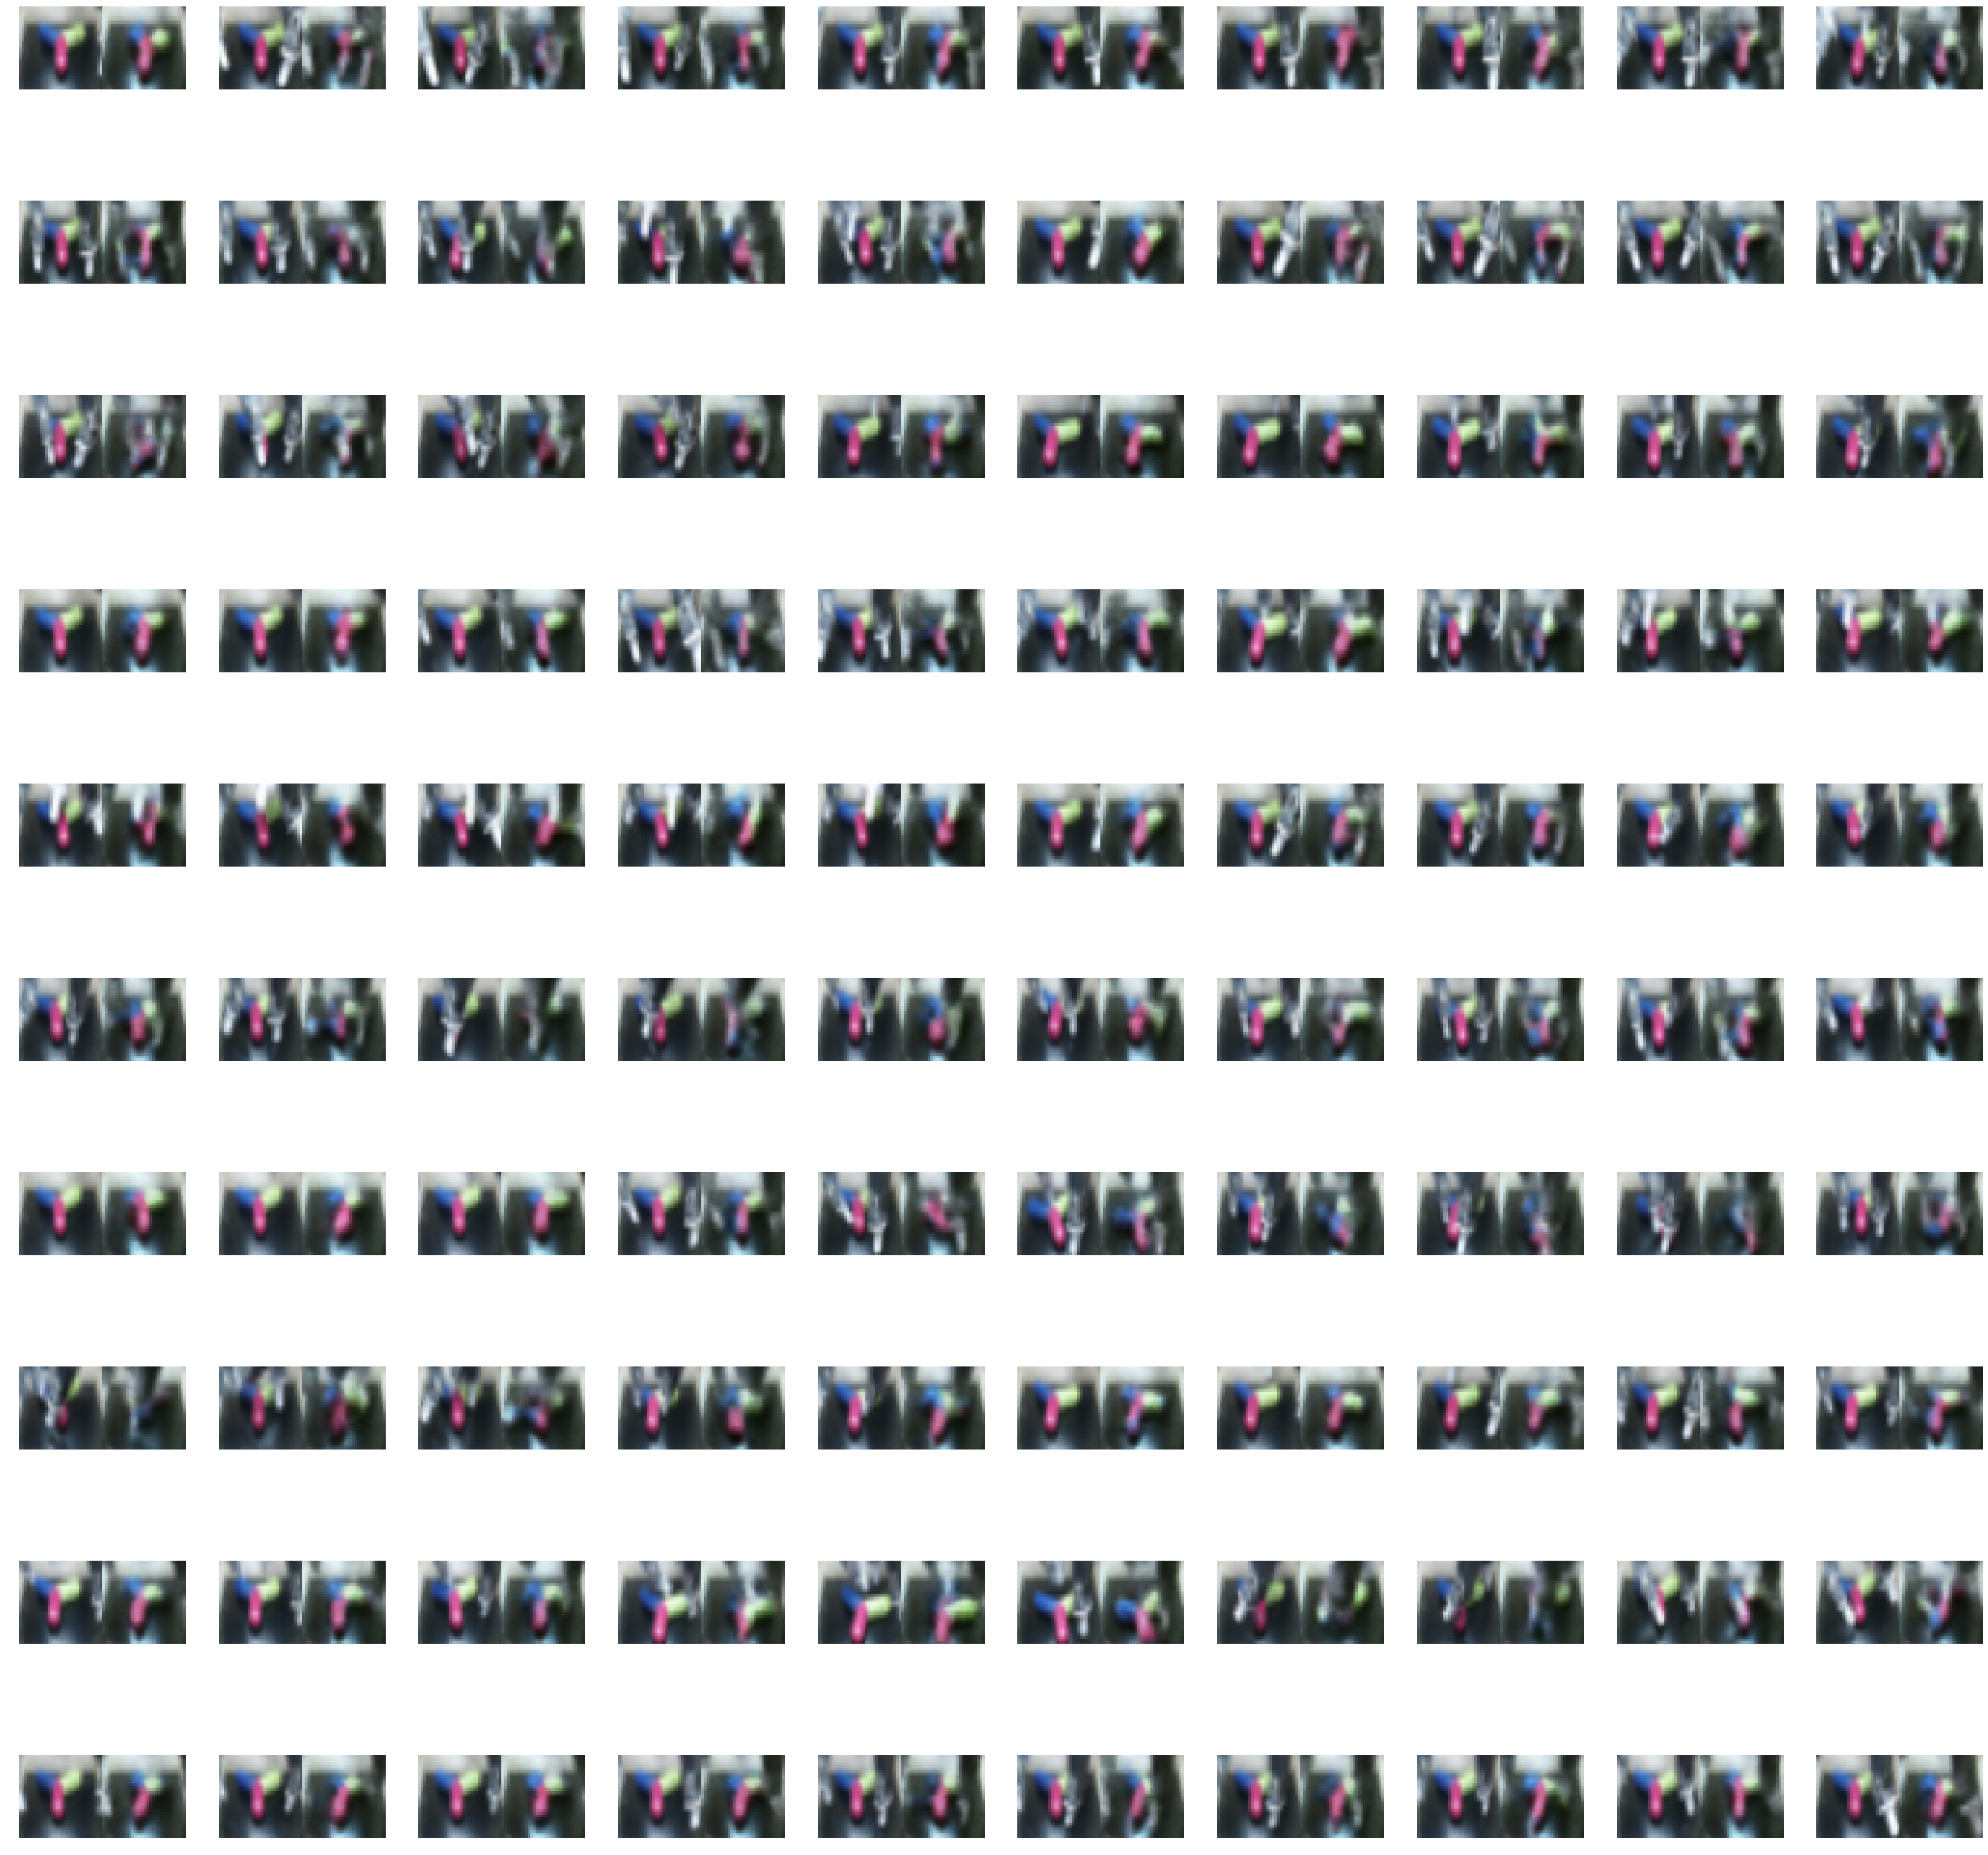

In [34]:
plot_grid(concat[:100])

# Fixed Goal Classifier (Reward over time)

## Load all the checkpoint replay pool data

In [7]:
# load pools
num_replay_pools = 2
def get_replay_pools_pickle_paths(checkpoint_dir):
    return [os.path.join(checkpoint_dir, f'replay_pool_{i}.pkl')
            for i in range(num_replay_pools)]

experience_paths_per_replay_pool = [get_replay_pools_pickle_paths(checkpoint_dir) 
 for checkpoint_dir in sorted(glob.iglob(os.path.join(experiment_root, 'checkpoint_*')))]

from softlearning.replay_pools.utils import get_replay_pool_from_variant
variant = checkpoint['variant']
variant['replay_pool_params']['kwargs']['max_size'] = len(experience_paths_per_replay_pool) * (10 * 1000)
training_environment = checkpoint['training_environment']
replay_pools = [get_replay_pool_from_variant(variant, training_environment) for _ in range(num_replay_pools)]

for experience_paths in experience_paths_per_replay_pool:
    for i, experience_path in enumerate(experience_paths):
        replay_pools[i].load_experience(experience_path)

In [8]:
non_zero_rows = replay_pools[0].data[('observations', 'claw_qpos')].any(axis=-1)
fw_pixels = replay_pools[0].data[('observations', 'pixels')][non_zero_rows]
fw_claw_qpos = replay_pools[0].data[('observations', 'claw_qpos')][non_zero_rows]

In [9]:
reset_non_zero_rows = replay_pools[1].data[('observations', 'claw_qpos')].any(axis=-1)
reset_pixels = replay_pools[1].data[('observations', 'pixels')][reset_non_zero_rows]
reset_claw_qpos = replay_pools[1].data[('observations', 'claw_qpos')][reset_non_zero_rows]

In [35]:
non_zero_rows.shape

(1010000,)

In [36]:
fw_pixels.shape

(1010000, 32, 32, 3)

In [37]:
fw_claw_qpos.shape

(1010000, 9)

In [38]:
goal_classifier = rw_classifiers[0]

In [39]:
rewards = goal_classifier.predict(fw_pixels)

In [40]:
# Record end of each iteration
# 250 path length --> every 250, 1000 steps per epoch --> average over every 4 data points?

path_length = variant['sampler_params']['kwargs']['max_path_length']
num_steps_per_epoch = variant['algorithm_params']['kwargs']['epoch_length']

In [41]:
path_length, num_steps_per_epoch

(250, 1000)

In [42]:
end_idxs = np.arange(rewards.shape[0], step=path_length) + path_length - 1

In [43]:
end_reward = rewards[end_idxs]

In [44]:
end_idxs.shape

(4040,)

In [45]:
num_to_avg = num_steps_per_epoch // path_length

In [46]:
epoch_end_rewards = np.array(np.split(end_reward, end_reward.shape[0] // num_to_avg))

In [47]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [48]:
epoch_end_reward_avgs = np.mean(epoch_end_rewards, axis=1)

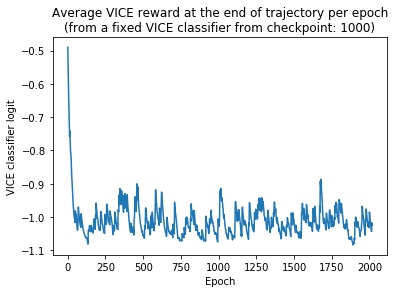

In [49]:
plt.title('Average VICE reward at the end of trajectory per epoch\n'
           f'(from a fixed VICE classifier from checkpoint: {checkpoint_to_analyze})')
plt.ylabel('VICE classifier logit')
plt.xlabel('Epoch')
plt.plot(np.arange(epoch_end_reward_avgs.shape[0]) * 2,
         smooth(epoch_end_reward_avgs, weight=0.9))
plt.show()

## State estimation

In [50]:
# Get start state at each reset trajectory (which should be the end state of the forward policy)
start_idxs = np.arange(reset_pixels.shape[0], step=path_length)

In [51]:
final_states = reset_pixels[start_idxs]

In [52]:
final_rewards = goal_classifier.predict(final_states)

In [53]:
final_epoch_rewards = np.array(np.split(final_rewards, final_rewards.shape[0] // num_to_avg))
final_epoch_rewards_avg = np.mean(final_epoch_rewards, axis=1)

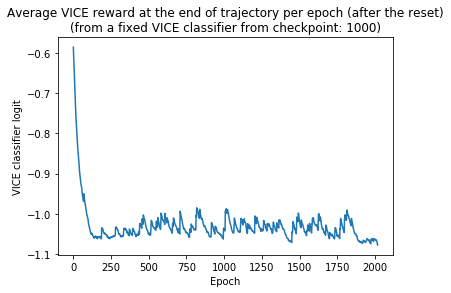

In [54]:
plt.title('Average VICE reward at the end of trajectory per epoch (after the reset)\n'
           f'(from a fixed VICE classifier from checkpoint: {checkpoint_to_analyze})')
plt.ylabel('VICE classifier logit')
plt.xlabel('Epoch')
plt.plot(np.arange(final_epoch_rewards_avg.shape[0]) * 2,
         smooth(final_epoch_rewards_avg, weight=0.95))
plt.show()

In [55]:
img = final_states[0].copy()

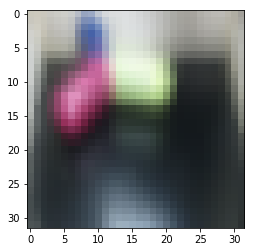

In [56]:
plt.imshow(img)

In [57]:
blue_weights = np.zeros((img.shape[:2] + (2, )))
print(blue_weights.shape)
for i in range(blue_weights.shape[0]):
    for j in range(blue_weights.shape[1]):
        blue_weights[i, j, 0] = np.max(2 * img[i, j, 2] ** 2 / np.product(img[i, j, :2]), 0)
        blue_weights[i, j, 1] = np.max(2 * img[i, j, 2] ** 2 / np.product(img[i, j, :2]), 0)

(32, 32, 2)


In [58]:
norm_blue_weights_x = blue_weights[..., 0] / np.sum(blue_weights[..., 0])

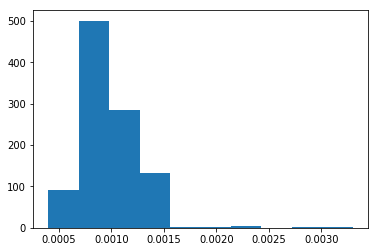

In [59]:
plt.hist(norm_blue_weights_x.flatten())
plt.show()
binarized_x = np.where(norm_blue_weights_x < 0.0015, 0, 1)

In [60]:
binarized_x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [61]:
binarized_x = binarized_x / np.sum(binarized_x)

In [62]:
blue_centroid_x = np.sum(binarized.dot(np.arange(norm_blue_weights_x.shape[0])))

NameError: name 'binarized' is not defined

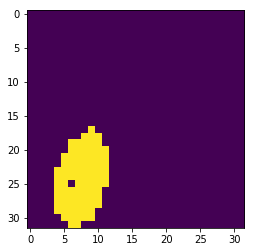

In [195]:
norm_blue_weights_y = blue_weights[..., 1] / np.sum(blue_weights[..., 1])
binarized_y = np.where(norm_blue_weights_y < 0.0015, 0, 1)
plt.imshow(binarized_y)
plt.show()
binarized_y = binarized_y / np.sum(binarized_y)
blue_centroid_y = np.sum(binarized_y.T.dot(np.arange(norm_blue_weights_y.shape[1])))

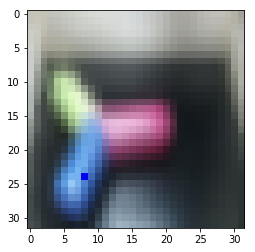

In [200]:
visual = img.copy()
visual[int(round(blue_centroid_y)), int(round(blue_centroid_x)), :] = np.array([0, 0, 255])
plt.imshow(visual)

In [65]:
img = final_states[np.argmin(final_rewards)].copy()
centroids = find_centroids(img)

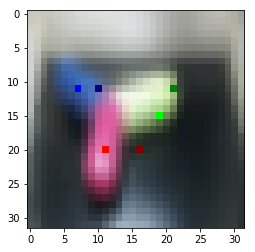

In [66]:
visual = img.copy()
for ((x, y, color), (goal_x, goal_y, goal_color)) in zip(centroids, goal_centroids):
    visual[int(round(y)), int(round(x)), :] = color
    visual[int(round(goal_y)), int(round(goal_x)), :] = goal_color
    
plt.imshow(visual)

In [28]:
def find_centroids(img):
    img = img.copy().astype(np.float32)
    
    centroids = []
#     for c in range(3):
#         weights = np.zeros((img.shape[:2]))
#         for i in range(weights.shape[0]):
#             for j in range(weights.shape[1]):
#                 weights[i, j] = np.max(img[i, j, c] ** 2 / (np.product(img[i, j, :]) / img[i, j, c]), 1e-4)
               
    weights = np.square(img) / (np.product(img, axis=2)[..., np.newaxis] / img)

    for c in range(3):
        norm_weights = weights[..., c] / np.sum(weights[..., c])

        if c == 1:
            binarized = np.where(norm_weights < 0.0011, 0, 1)            
        else:
            binarized = np.where(norm_weights < 0.0014, 0, 1)
        if np.sum(binarized) == 0:
#             print("CHANNEL: ", c)
            return None

        binarized = binarized / np.sum(binarized)
        centroid_x = np.sum(binarized.dot(np.arange(norm_weights.shape[0])))
        centroid_y = np.sum(binarized.T.dot(np.arange(norm_weights.shape[1])))
        centroids.append([centroid_x, centroid_y])

    return np.array(centroids)

In [16]:
goal_centroids = np.array([ # r, g, b
    [15.5, 20],
    [21, 11],
    [10, 11]
])

In [17]:
def get_distance_from_goal(centroids, goal_centroids):
    """
    Returns object position/orientation distance as a sum of the distance of the
    RGB centroids to the RGB goal positions in units of pixel distance [0, 32].
    """
    return np.sum(np.linalg.norm(centroids - goal_centroids, axis=1))

In [73]:
img = final_states[np.argmax(final_rewards)].copy()
centroids = find_centroids(img)

In [ ]:
def visualize_centroids(img, centroids, goal_centroids):
    visual = img.copy()
    for i, (c, gc) in enumerate(zip(centroids, goal_centroids)):
        print(c, gc)
        visual[int(round(c[1])), int(round(c[0])), :] = 255 * np.eye(3)[i]
        visual[int(round(gc[1])), int(round(gc[0])), :] = 128 * np.eye(3)[i]
    plt.imshow(visual)

In [75]:
distances = []
all_centroids = []
for img in final_states:
    centroids = find_centroids(img)
    if centroids:
        all_centroids.append(centroids)
        distances.append(get_distance_from_goal(centroids, goal_centroids))
distances = np.array(distances)
all_centroids = np.array(all_centroids)

In [76]:
get_distance_from_goal(centroids, goal_centroids)

32.89914818867956

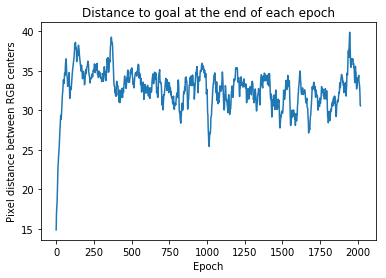

In [77]:
plt.title('Distance to goal at the end of each epoch')
plt.ylabel('Pixel distance between RGB centers')
plt.xlabel('Epoch')
epoch_distances = np.array(np.split(distances, distances.shape[0] // num_to_avg))
epoch_distances_avg = np.mean(epoch_distances, axis=1)
plt.plot(
    np.arange(epoch_distances_avg.shape[0] * 2, step=2),
    smooth(epoch_distances_avg, weight=0.9))
plt.show()

In [78]:
rand_idxs = np.random.choice(final_states.shape[0], size=64)
rand_centroids = all_centroids[rand_idxs]
rand_imgs = final_states[rand_idxs]

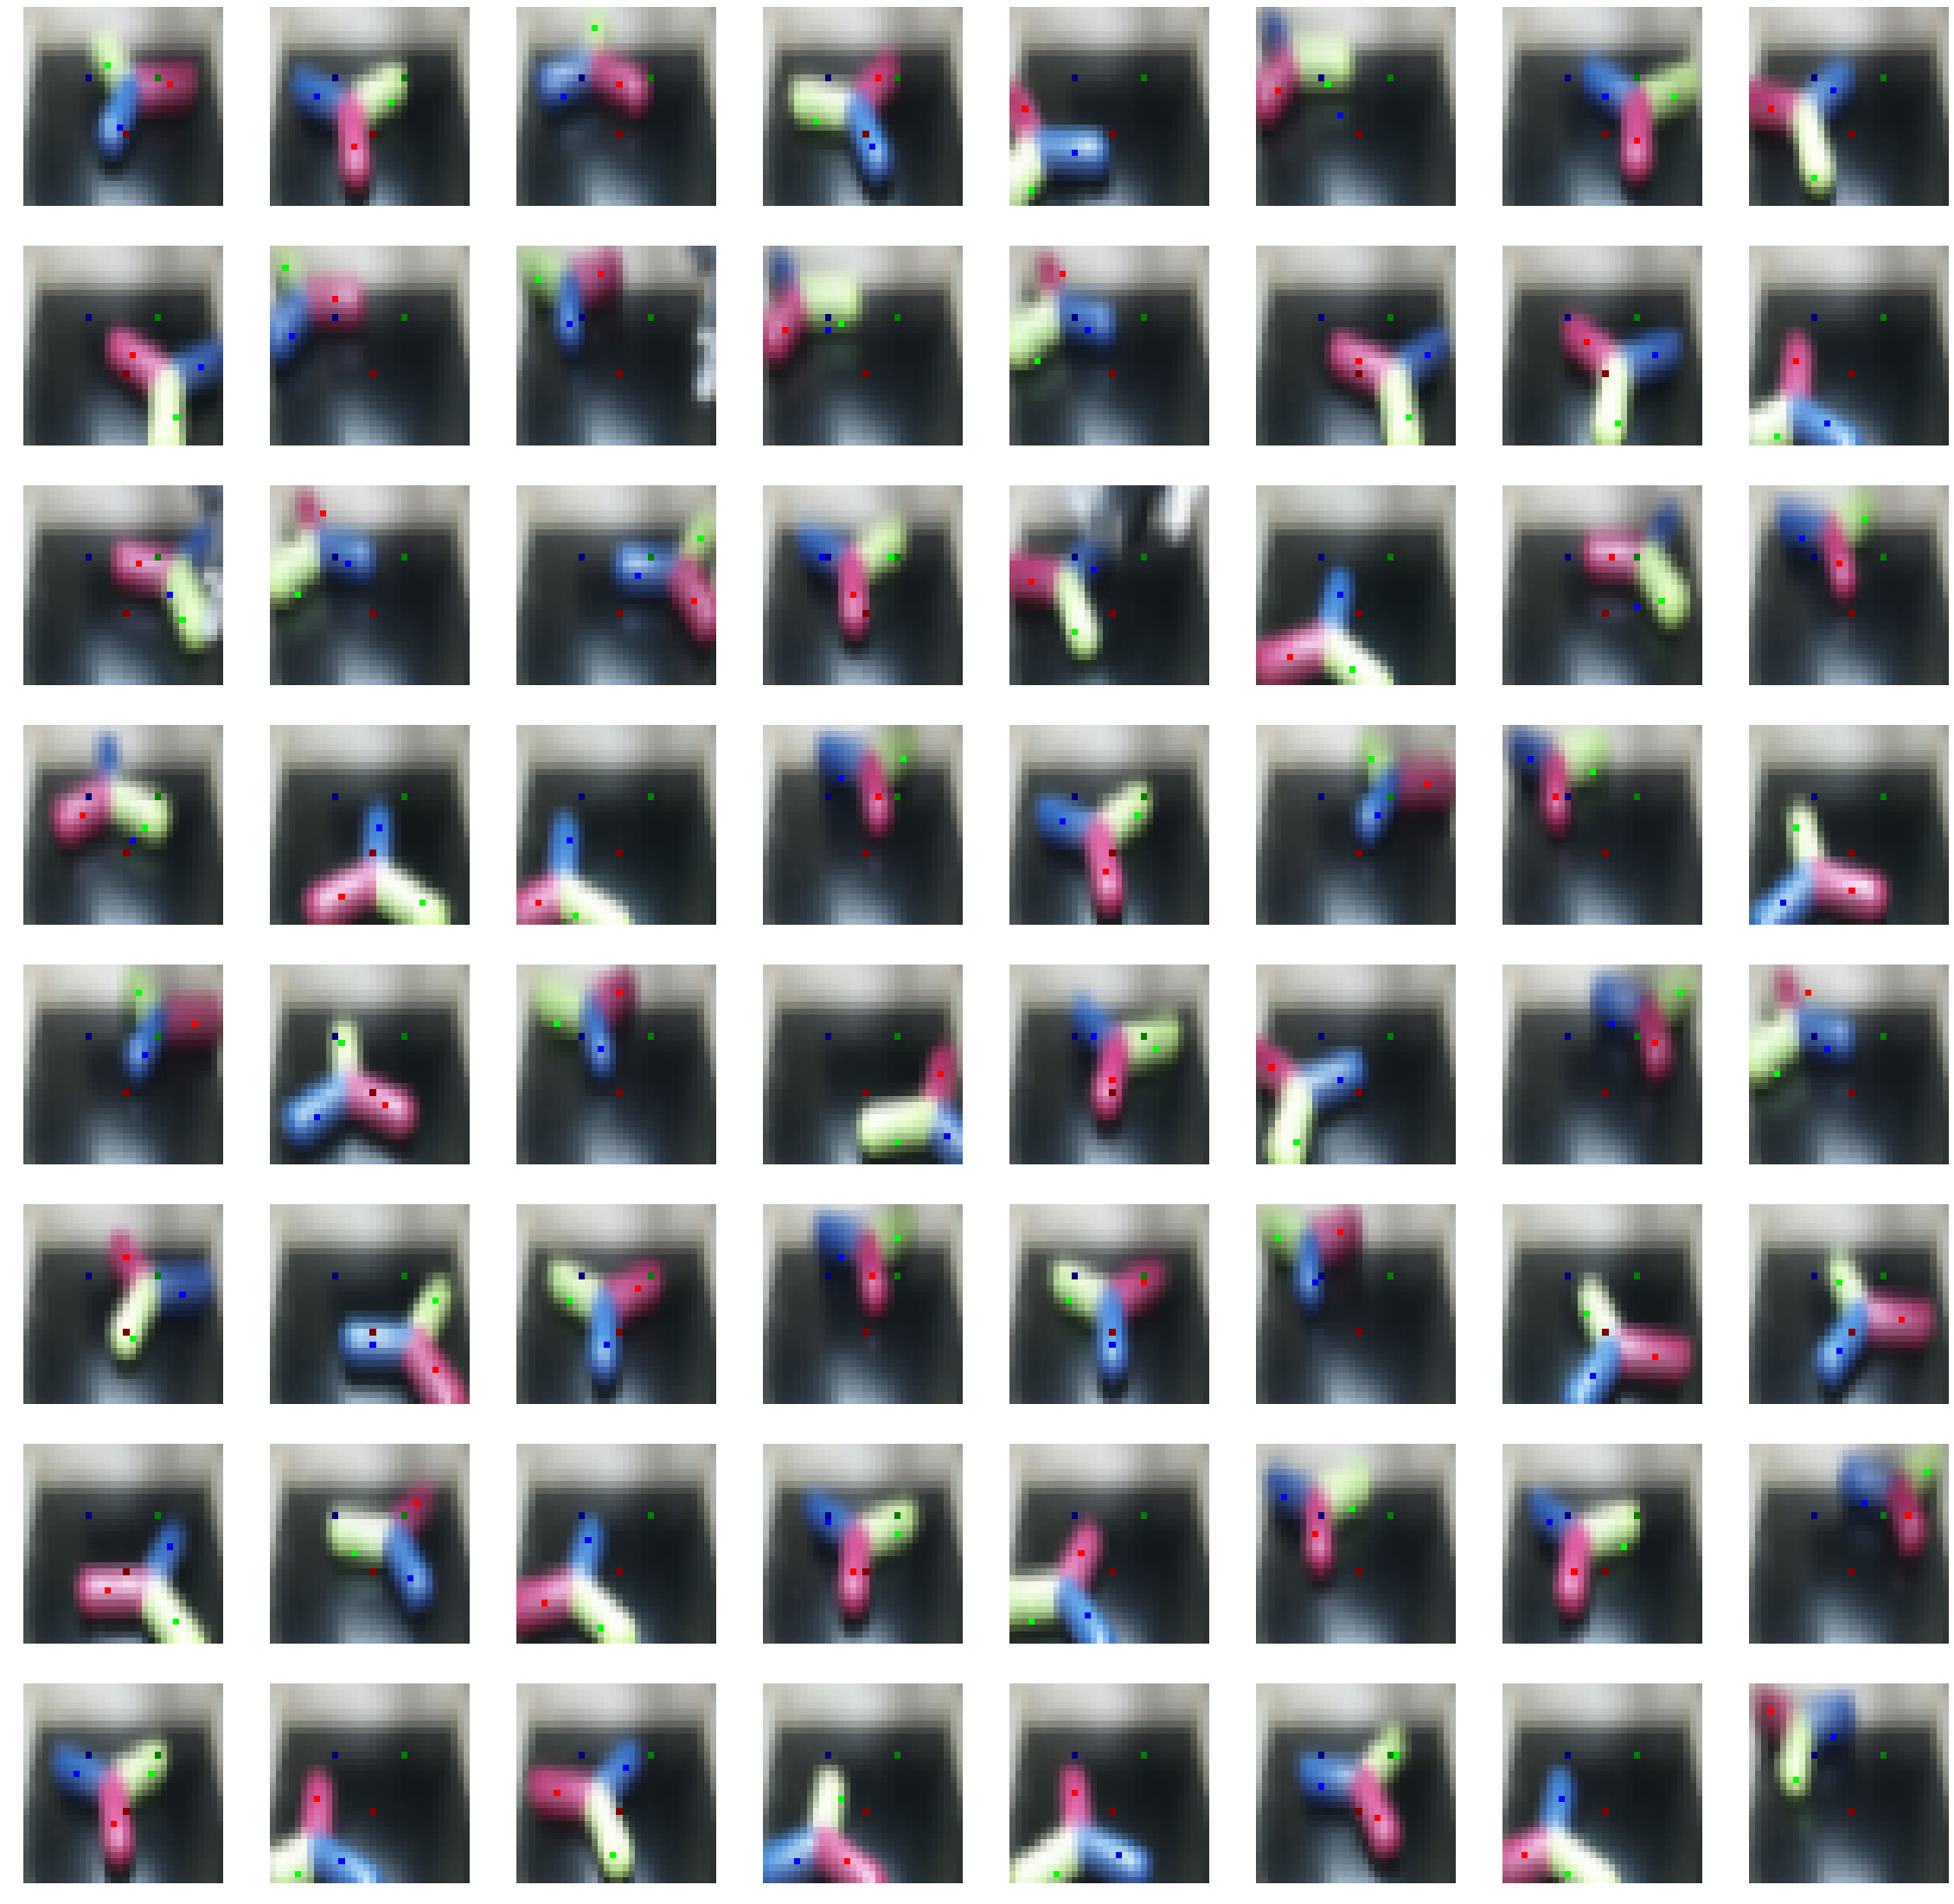

In [81]:
visualizations = []
for i, (img, centroids) in enumerate(zip(rand_imgs, rand_centroids)):
    img = img.copy()
    for i, (c, gc) in enumerate(zip(centroids, goal_centroids)):
        img[int(round(c[1])), int(round(c[0])), :] = 255 * np.eye(3)[i]
        img[int(round(gc[1])), int(round(gc[0])), :] = 128 * np.eye(3)[i]
    visualizations.append(img)

plot_grid(visualizations)

## Collecting False Positives with Center Distance

In [29]:
# Look at the bottom half of the distribution
rw_filter = (rewards < reward_mean - 0.25 * reward_stdev).squeeze()
rw = rewards[rw_filter]
bottom_half_images = fw_pixels[rw_filter]
print('# of images:', bottom_half_images.shape[0])

# of images: 384796


In [30]:
distances = []
all_centroids = []
idxs = []
for i, img in enumerate(bottom_half_images):
    centroids = find_centroids(img)
    if centroids is not None:
        all_centroids.append(centroids)
        distances.append(get_distance_from_goal(centroids, goal_centroids))
        idxs.append(i)
idxs = np.array(idxs)
imgs_used = bottom_half_images[idxs]
distances = np.array(distances)
all_centroids = np.array(all_centroids)

In [39]:
k = int(1e4)

smallest_idxs = np.argpartition(distances, k)[:k]
closest_imgs, closest_centroids = imgs_used[smallest_idxs], all_centroids[smallest_idxs]
closest_distances = distances[smallest_idxs]

In [25]:
visualizations = []
for i, (img, centroids) in enumerate(zip(closest_imgs, closest_centroids)):
    img = img.copy()
    for i, (c, gc) in enumerate(zip(centroids, goal_centroids)):
        img[int(round(c[1])), int(round(c[0])), :] = 255 * np.eye(3)[i]
        img[int(round(gc[1])), int(round(gc[0])), :] = 128 * np.eye(3)[i]
    visualizations.append(img)

plot_grid(visualizations)

TypeError: 'numpy.float64' object does not support item assignment

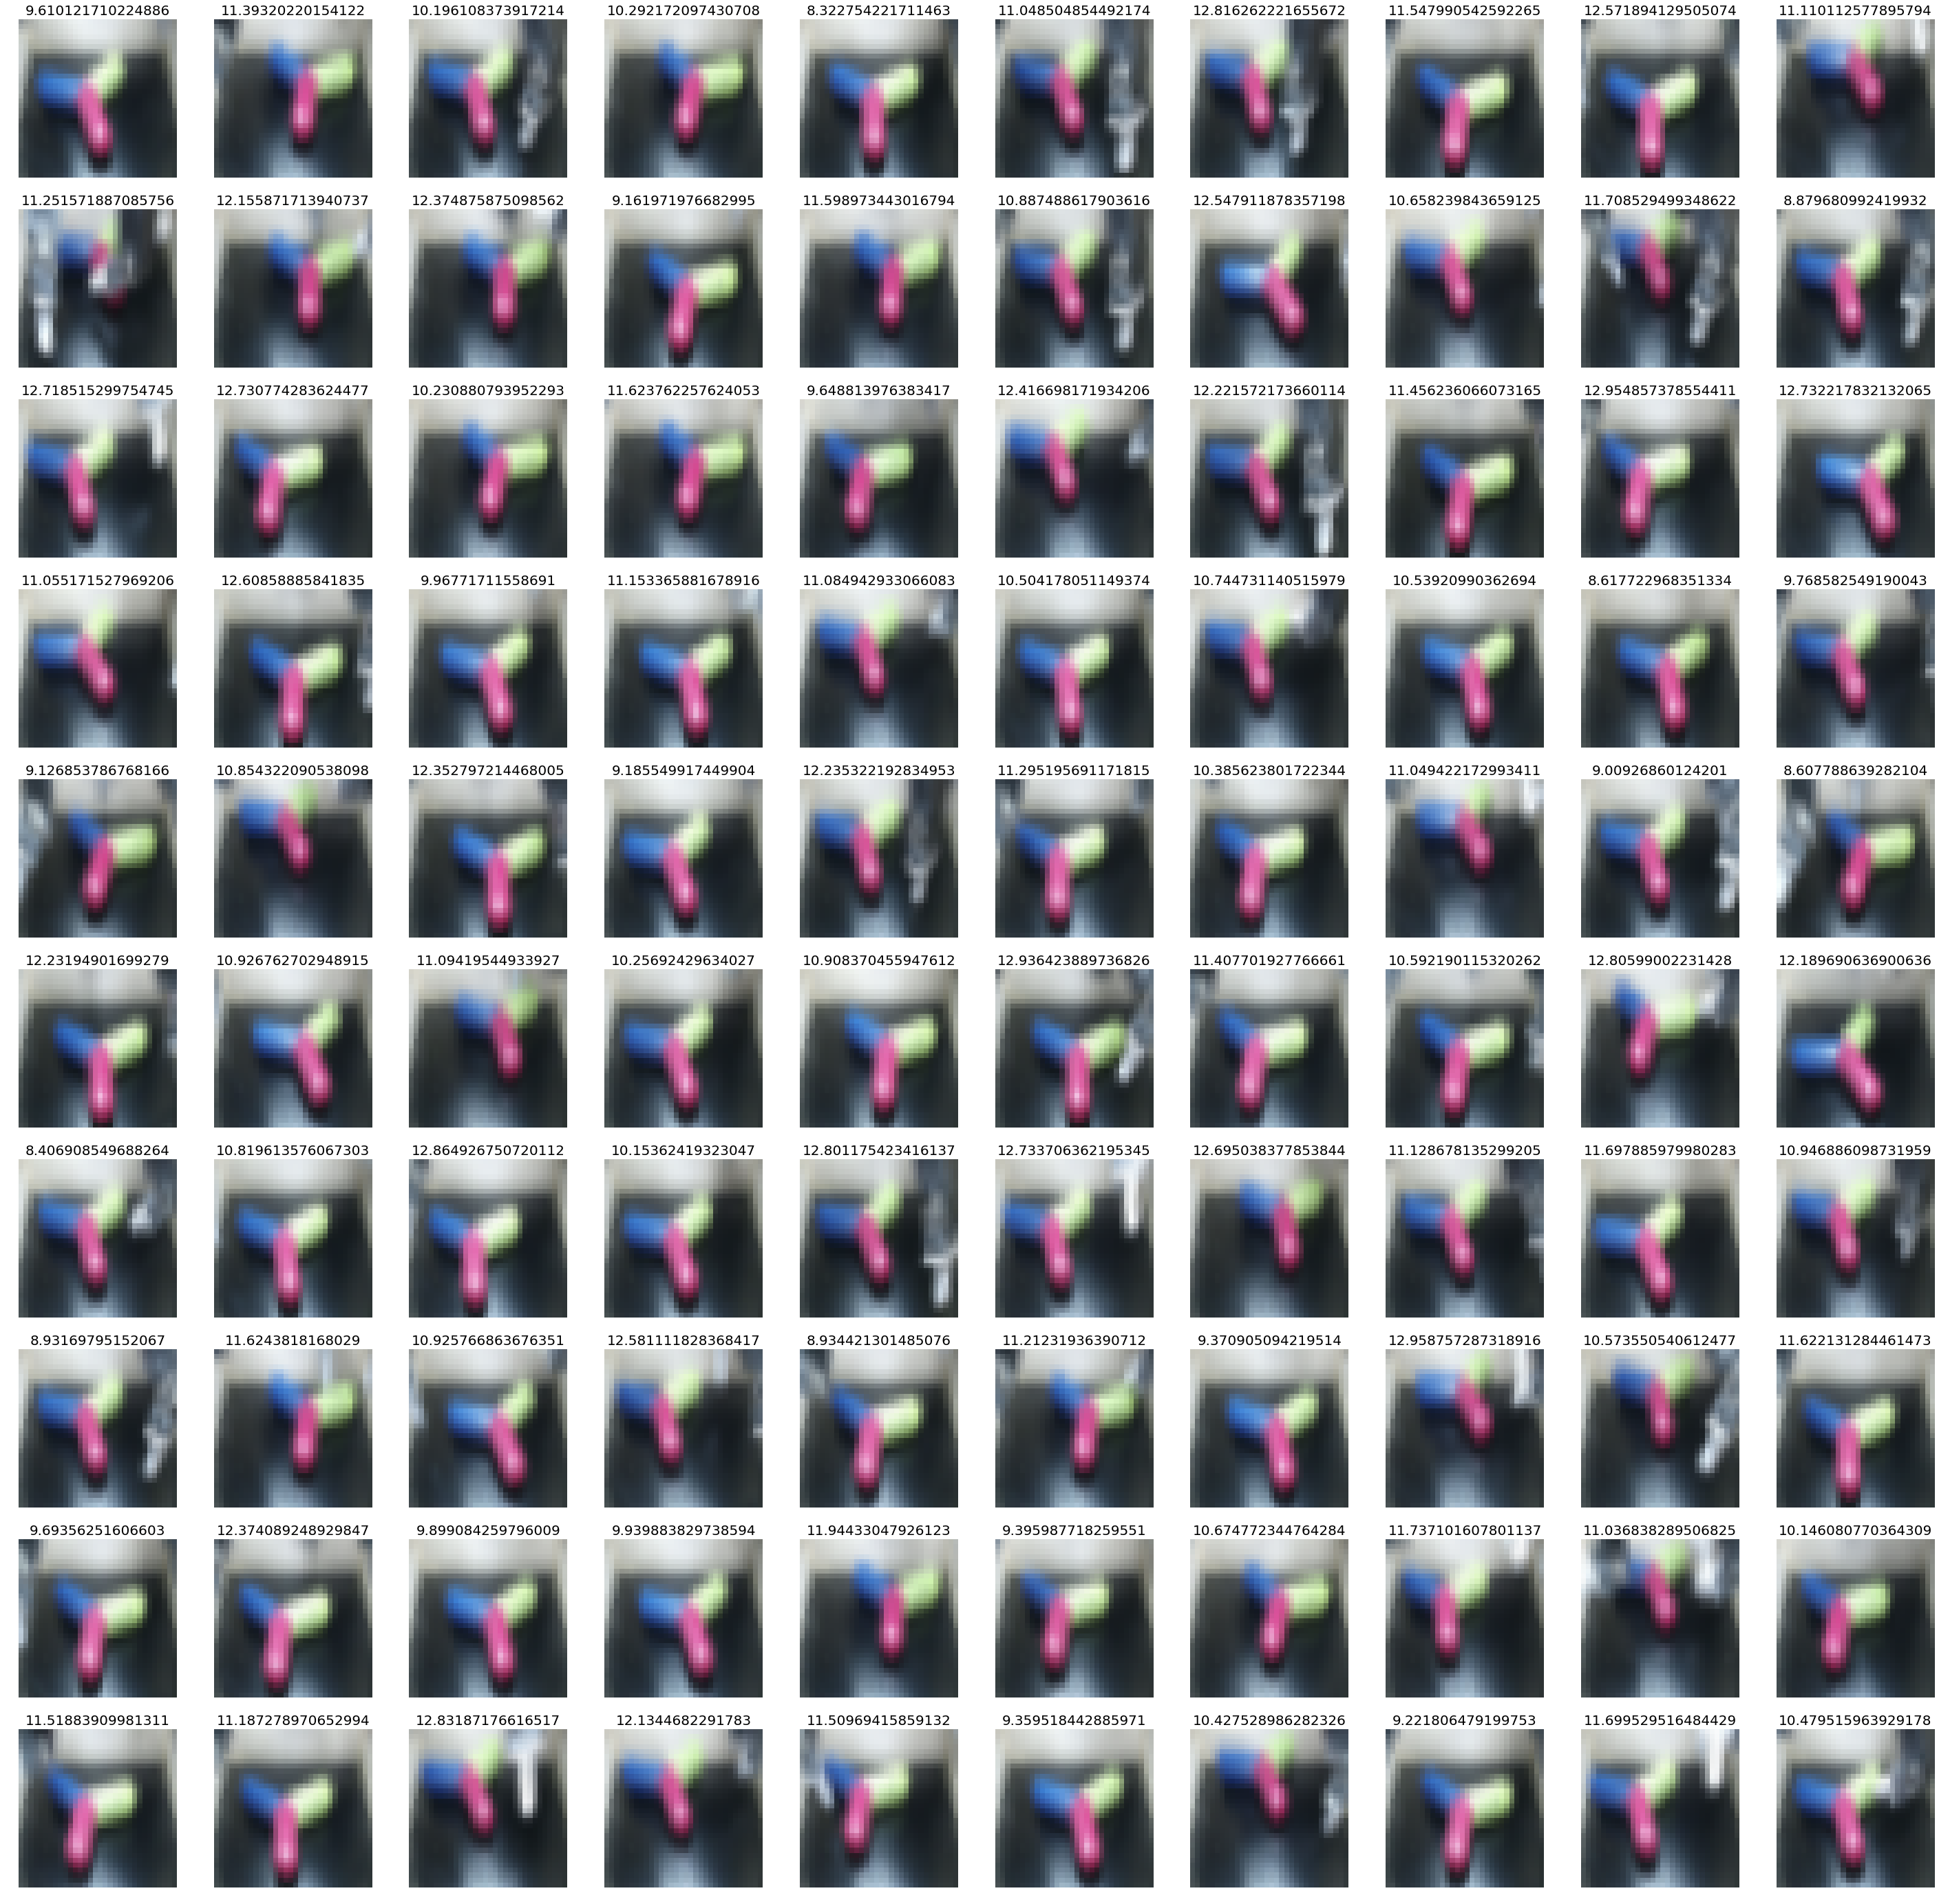

In [55]:
rand_idxs = np.random.choice(closest_imgs.shape[0], size=100)
rand_centroids = all_centroids[rand_idxs]
rand_imgs = closest_imgs[rand_idxs]
plot_grid(rand_imgs, labels=closest_distances[rand_idxs])

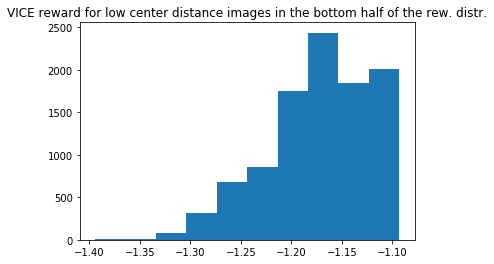

In [45]:
plt.title('VICE reward for low center distance images in the bottom half of the rew. distr.')
plt.hist(rw_classifiers[0].predict(closest_imgs))
plt.show()

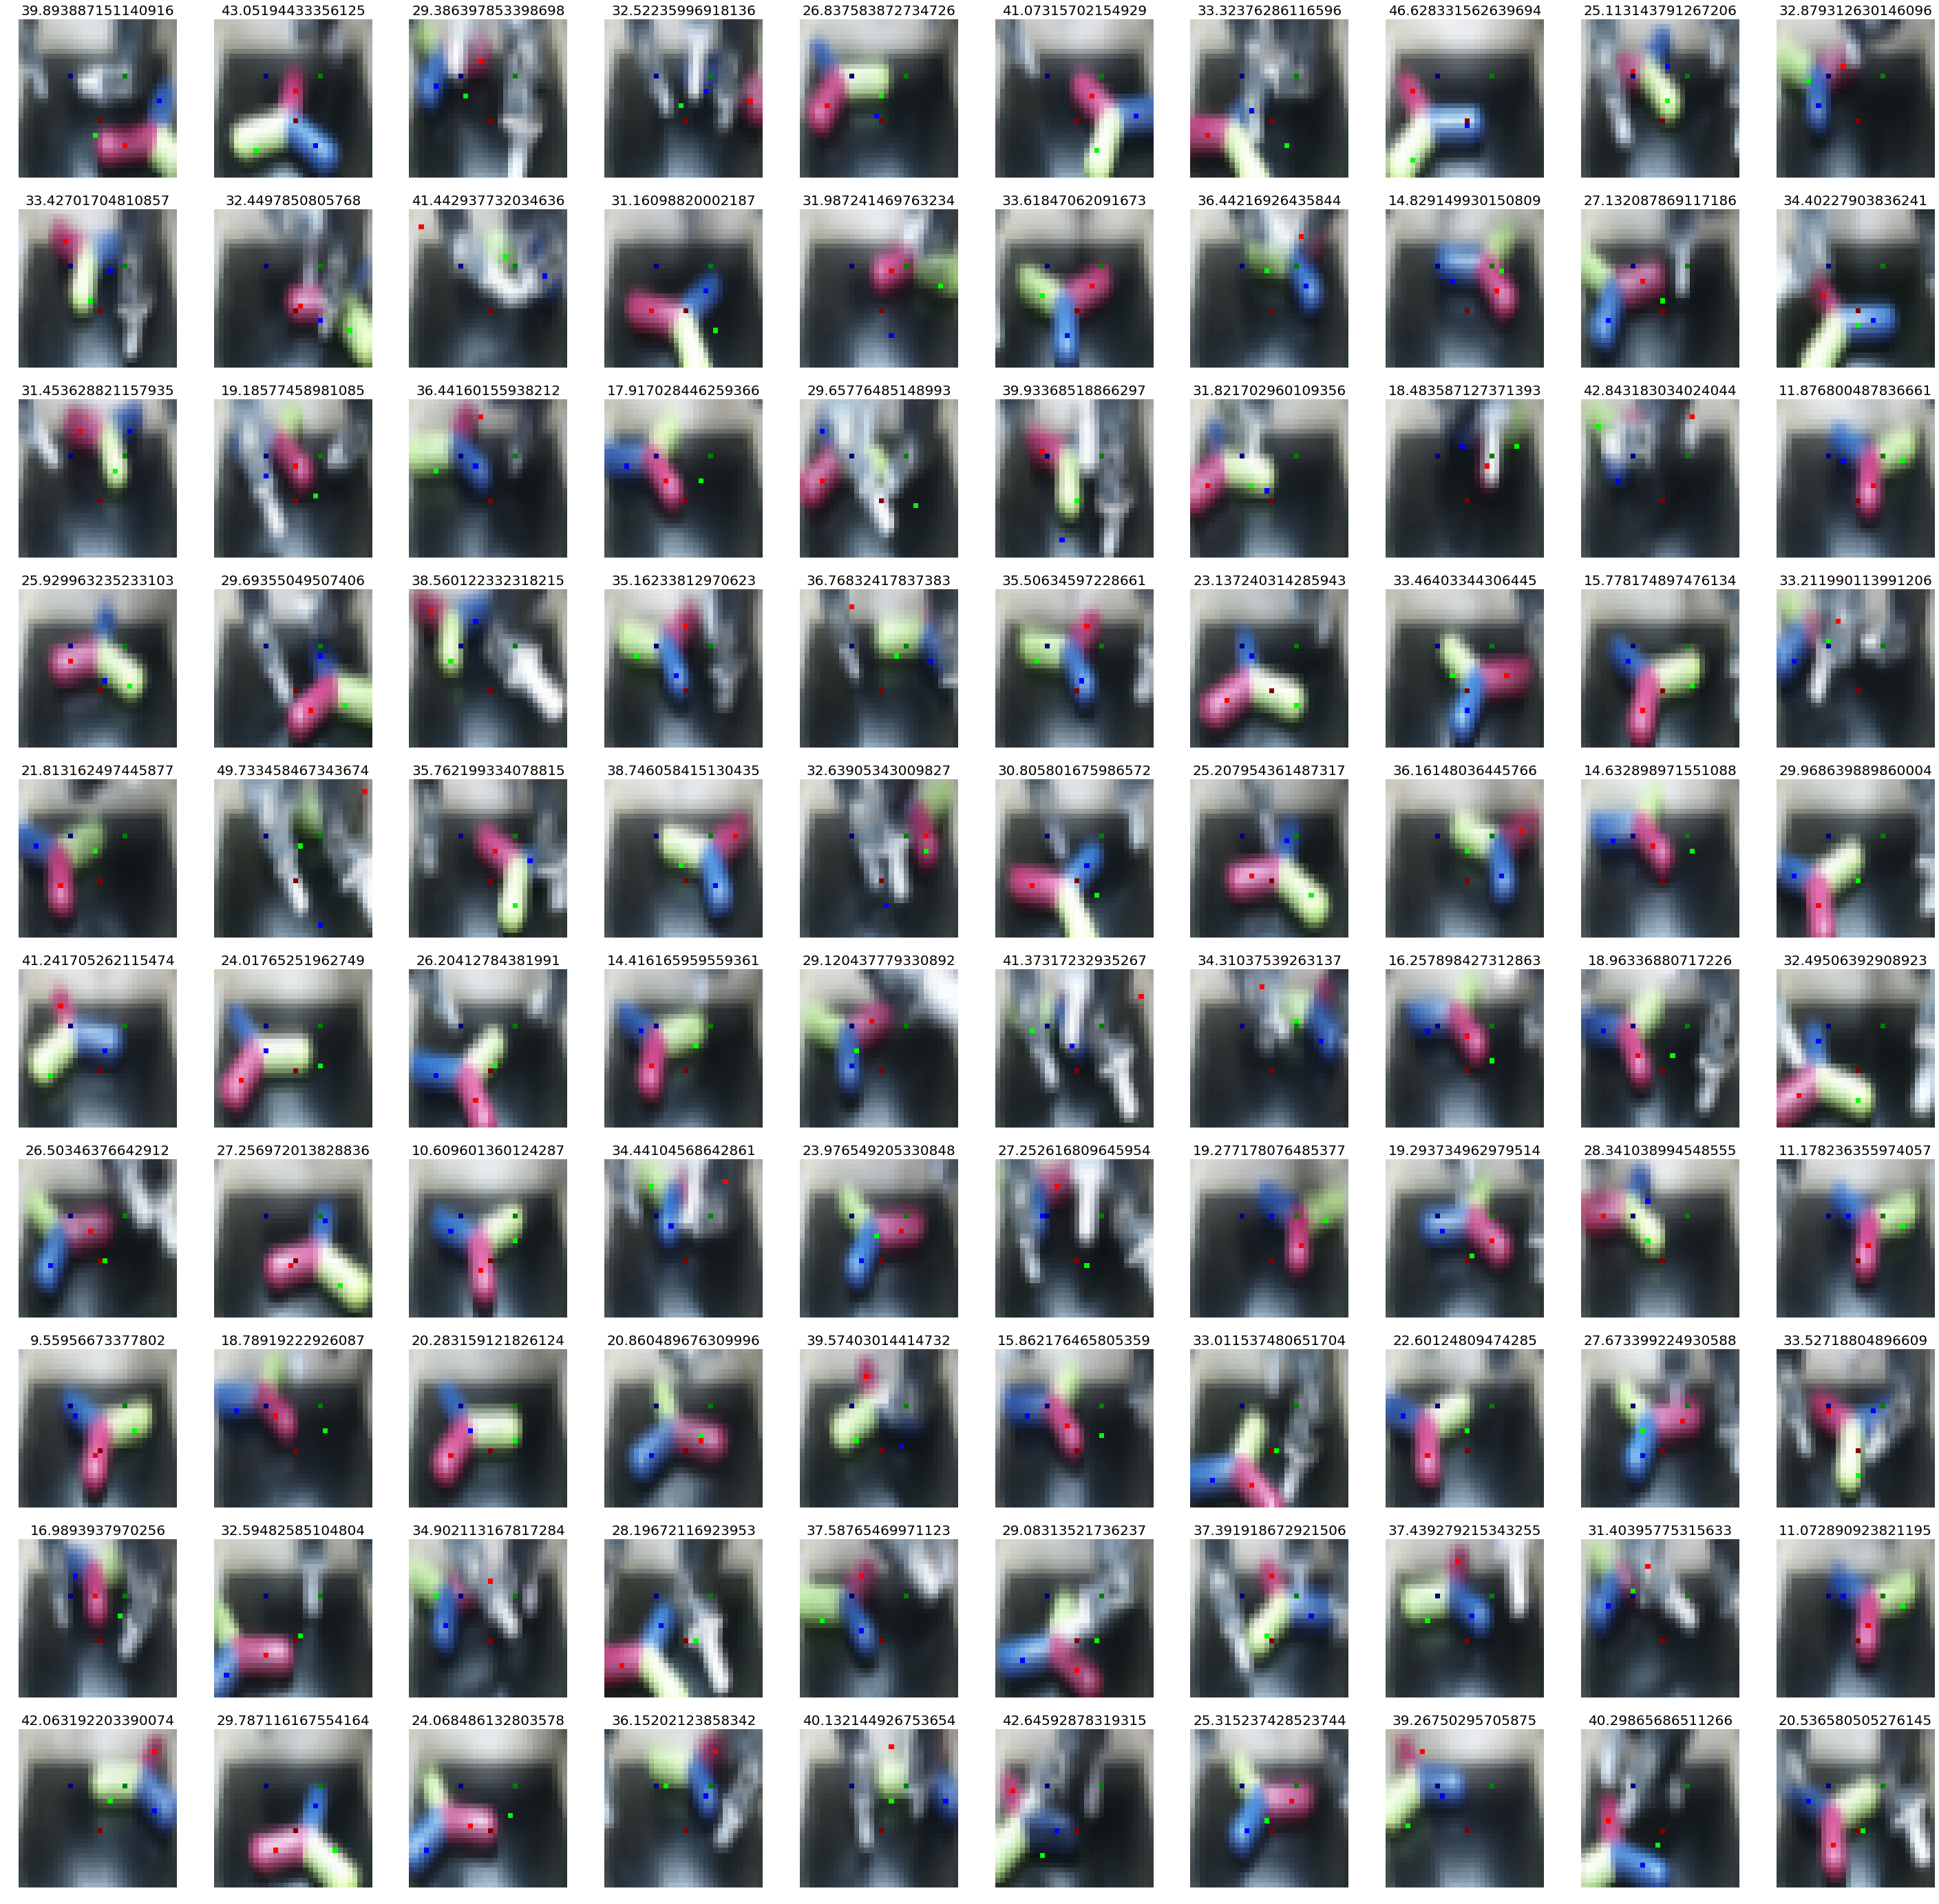

In [53]:
k = 100

rand_idxs = np.random.choice(imgs_used.shape[0], size=100)
rand_centroids = all_centroids[rand_idxs]
rand_imgs = imgs_used[rand_idxs]
# plot_grid(rand_imgs, labels=distances[rand_idxs])

visualizations = []
for i, (img, centroids) in enumerate(zip(rand_imgs, rand_centroids)):
    img = img.copy()
    for i, (c, gc) in enumerate(zip(centroids, goal_centroids)):
        img[int(round(c[1])), int(round(c[0])), :] = 255 * np.eye(3)[i]
        img[int(round(gc[1])), int(round(gc[0])), :] = 128 * np.eye(3)[i]
    visualizations.append(img)

plot_grid(visualizations, labels=distances[rand_idxs])